In [6]:
# coding: utf-8

import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import jellyfish
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats

In [7]:
def rmse(model, obs):
    mse = np.nanmean((obs.values - model.values)**2)
    return np.sqrt(mse)
def calcNear0Model(df):
    
    maskNear0 = (df['T2 (C)'] > -2) & (df['T2 (C)'] < 2)
    maskNear0_precip = ((df['T2 (C)'] > -2) & (df['T2 (C)'] < 2)) & (df['PR (mm)'] > 0.1)
    maskNear0_precip02 = ((df['T2 (C)'] > -2) & (df['T2 (C)'] < 2)) & (df['PR (mm)'] > 0.2)

    #maskNear0_precip = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Precip. Amount (mm)'] > 0.1)
    #maskNear0_precip02 = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Precip. Amount (mm)'] > 0.2)
    
    near0 = len(df[maskNear0])
    near0_01 = len(df[maskNear0_precip])
    near0_02 = len(df[maskNear0_precip02])
        
    return near0, near0_01, near0_02

def calcNear0(df):
    
    maskNear0 = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2)
    #maskNear0_precip = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Weather'].str.contains("Rain|Snow|Drizzle|Thunderstorm|Showers|Ice")==True)
    maskNear0_precip = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Weather'].str.contains("Rain|Snow|Thunderstorm|Showers|Ice Pellets")==True)

    #maskNear0_precip = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Precip. Amount (mm)'] > 0.1)
    #maskNear0_precip02 = (df['Temp (°C)'] > -2) & (df['Temp (°C)'] < 2) & (df['Precip. Amount (mm)'] > 0.2)
    
    near0 = len(df[maskNear0])
    near0_01 = len(df[maskNear0_precip])
    #near0_02 = len(df[maskNear0_precip02])
        
    return near0, near0_01, near0_01

def calcDist(df):
    l = np.arange(-50,48,4)
    dist = np.zeros(len(l))
    aux = np.full((len(df)), True)
    
    for i in range(len(l)):
      # if first item
        if i == 0:        
            aux = np.where(df<l[i], True, False)
      # last item
        elif i == len(l)-1:
            aux = np.where(df>=l[i], True, False)
        # do something else
      # all the other numbers
        else:
            aux = np.logical_and(df>=l[i-1], df<l[i])
        
        aux = np.sum(aux, axis=0)
        dist[i] += aux
        
    return dist

# Function to find the two peaks in the distribution
def get_2peaks(dist):
    from scipy.signal import find_peaks

    #t = time.process_time()
    peaks, x = find_peaks(dist, height=0, distance=1)

    # get the first and second peak
    heights = x['peak_heights']
    sort_index = np.argsort(heights)
    first = peaks[sort_index[-1]]
    if len(sort_index) == 1:
        second = -1
    else:        
        second = peaks[sort_index[-2]]
    
    return first, second

In [9]:
f = '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime'
#provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']
provinces = next(os.walk(f'{f}'))[1]
datei = datetime(2000,10,1,0)
datef = datetime(2013,9,30,23)

arq = open('stations_dist_v4_test.dat', 'w')
arq.write('CITY;LAT;LON;PEAK1;PEAK2;NEAR0;NEAR0_P01;NEAR0_P02;MEAN;STD;MODEL_MEAN;MODEL_STD;RMSE;BIAS;NEAR0_M;NEAR0_P01_M;NEAR0_P02_M\n')

model = '/home/cruman/Scripts/EventDistributionT2M/CSV'

for pv in provinces:
    cities = next(os.walk(f'{f}/{pv}'))[1]
    print(cities)
    #print(cities)
    files_old = 0
    city_old = ""
    for c in np.sort(cities):
        data = next(os.walk(f'{f}/{pv}/{c}'))[1]
        print(data)
#        if 'MONT' not in c:
#            continue
        #data = list_files(f'{f}/{pv}/{c}')
        if (jellyfish.jaro_winkler_similarity(city_old, c) >= 0.83):
            files = files_old
        else:
            files = []
            
        for item in data:
            print(c, item)
            files += glob(f'{f}/{pv}/{c}/{item}/*csv')
                        
        df = pd.concat((pd.read_csv(ff) for ff in files))
        df['Date/Time (LST)'] = pd.to_datetime(df['Date/Time (LST)'])
        
        mask = (df['Date/Time (LST)'] > datei) & (df['Date/Time (LST)'] <= datef)
        df = df.loc[mask]
        
        df = df.drop_duplicates(subset=['Date/Time (LST)'])
        df_aux = df['Temp (°C)'].dropna()
        
        '''
        aux = c.replace(' ','-').replace("'","_")
        df.to_csv(f'CSV_ECCC/{aux}.csv')
        continue
        '''
        print(len(df))
        print(len(df_aux))        
        # filter the df by the dates
        # Calculate the 'average number of years', to account for missing data
        # If the number of hours is less than 113952 (10y * 365d * 24h + 3y * 366d * 24h)
        # the value should be divided by a different number than 13.
        nyear = 13*len(df_aux)/113952
        if nyear==0:
            nyear=np.nan
        print(nyear)        
        
        # do the distribution of Temp and calculate near 0
        near0, near0_01, near0_02 = calcNear0(df)
        dist = calcDist(df['Temp (°C)'].to_numpy())
        mean = np.nanmean(df['Temp (°C)'].to_numpy())
        std = np.nanstd(df['Temp (°C)'].to_numpy())
        xlat = df['Longitude (x)'].iloc[0]
        ylon = df['Latitude (y)'].iloc[0]
        if (sum(dist) == 0):
            peak1, peak2 = 0, 0
        else:
            peak1, peak2 = get_2peaks(dist)
        # to do
        # Count the number of NaNs in a year, to be able to get the exact average number of hours.
        
        # Read the model data from the csv
        model_file = glob(f'{model}/{c[:5]}*CTRL*csv'.replace(' ', '_'))[0]
        df_m = pd.read_csv(model_file, index_col=0)
        df_m['Time'] = pd.to_datetime(df_m['Time'])
        mask2 = (df_m['Time'] > datei) & (df_m['Time'] <= datef)
        df_m = df_m[mask2]
        df_m['T2 (C)'] = df_m['T2 (K)'] - 273.15
        
        
       # model_file_pgw = glob(f'{model}/{c[:5]}*PGW*csv'.replace(' ', '_'))[0]
       # df_pgw = pd.read_csv(model_file_pgw, index_col=0)
       # df_pgw['Time'] = pd.to_datetime(df_pgw['Time'])
       # mask3 = (df_pgw['Time'] > datei) & (df_pgw['Time'] <= datef)
       # df_pgw = df_pgw[mask3]
       # df_pgw['T2 (C)'] = df_pgw['T2 (K)'] - 273.15
        
        # Plot and calculate the distribution
        
        # Merge the two datasets
        df_merged = pd.merge(left=df, right=df_m, left_on='Date/Time (LST)', right_on='Time')
        # Calculate the indices for the temperature
        val_rmse = rmse(df_merged['T2 (C)'], df_merged['Temp (°C)'])
        val_bias = np.nanmean(df_merged['Temp (°C)'].values) - np.nanmean(df_merged['T2 (C)'].values)
        mean_m = np.nanmean(df_merged['T2 (C)'].values)
        std_m = np.std(df_merged['T2 (C)'].values)
        near0_m, near0_01_m, near0_02_m = calcNear0Model(df_m)
        #sys.exit()
        arq.write(f'{c};{xlat};{ylon};{peak1};{peak2};{near0/nyear:.2f};{near0_01/nyear:.2f};{near0_02/nyear:.2f};{mean:.2f};{std:.2f};{mean_m:.2f};{std_m:.2f};{val_rmse:.2f};{val_bias:.2f};{near0_m/13.:.2f};{near0_01_m/13.:.2f};{near0_02_m/13.:.2f}\n')
        print(f'{c};{xlat};{ylon};{peak1};{peak2};{near0/nyear:.2f};{near0_01/nyear:.2f};{near0_02/nyear:.2f};{mean:.2f};{std:.2f};{mean_m:.2f};{std_m:.2f};{val_rmse:.2f};{val_bias:.2f};{near0_m/13.:.2f};{near0_01_m/13.:.2f};{near0_02_m/13.:.2f}\n')
        #sys.exit()
        files_old = files
        city_old = c
    #sys.exit()
arq.close()

["CALGARY INT'L A", 'CALGARY INTL A', 'COLD LAKE A', "EDMONTON INT'L A", 'EDMONTON INTL A', 'GRANDE PRAIRIE A']
['3031093_1953_2012']
CALGARY INT'L A 3031093_1953_2012
107399
103247
11.778740171300196
CALGARY INT'L A;-114.02;51.11;15;-1;1117.69;141.02;141.02;4.48;11.15;4.21;12.06;6.06;0.27;1287.15;83.23;61.00

['3031092_2012_2021']
CALGARY INTL A 3031092_2012_2021
113951
109790
12.52518604324628
CALGARY INTL A;-114.02;51.11;15;-1;1102.42;137.24;137.24;4.64;11.13;4.41;12.03;6.06;0.24;1287.15;83.23;61.00

['3081680_1954_2021']
COLD LAKE A 3081680_1954_2021
113951
113627
12.96292298511654
COLD LAKE A;-110.28;54.42;16;13;898.87;120.73;120.73;2.49;13.38;0.96;14.99;6.28;1.53;848.85;58.46;41.46

['3012205_1961_2012']
EDMONTON INT'L A 3012205_1961_2012
107399
101061
11.52935446503791
EDMONTON INT'L A;-113.58;53.32;13;16;1081.33;123.51;123.51;2.29;12.55;2.99;13.41;6.70;-0.69;1086.85;72.15;52.00

['3012216_2012_2021']
EDMONTON INTL A 3012216_2012_2021
113951
107580
12.273062342038752
EDMONTON IN

113951
113902
12.994295843864084
WINDSOR A;-82.96;42.28;18;13;1035.15;270.50;270.50;10.42;10.86;9.49;12.10;4.29;0.92;1007.00;122.00;90.38

['CHARLOTTETOWN A']
['8300300_1953_2012', '8300301_2012_2021']
CHARLOTTETOWN A 8300300_1953_2012
CHARLOTTETOWN A 8300301_2012_2021
113951
111216
12.687868576242629
CHARLOTTETOWN A;-63.13;46.29;13;17;1213.36;370.27;370.27;6.49;10.27;5.79;11.59;3.66;0.69;1174.54;202.38;157.15

['BAGOTVILLE A', 'GASPE A', 'KUUJJUARAPIK A', 'LA GRANDE RIVIERE A', 'MONT-JOLI A', 'MONTREAL INTL A', 'MONTREAL:PIERRE ELLIOTT TRUDEAU INTL A', 'QUEBEC INTL A', 'QUEBEC:JEAN LESAGE INTL A', 'ROUYN A', 'ROUYN-NORANDA A', 'SEPT-ILES A', 'MONT-JOLI_A']
['7060400_1953_2021']
BAGOTVILLE A 7060400_1953_2021
113951
113945
12.999201418140972
BAGOTVILLE A;-71.0;48.33;13;17;996.37;333.10;333.10;3.67;12.86;2.72;14.56;4.58;0.95;871.62;148.08;111.15

['7052601_2013_2021', '7052605_1965_2013']
GASPE A 7052601_2013_2021
GASPE A 7052605_1965_2013
113951
112202
12.80035453524291
GASPE A;-64.48;

<ipython-input-9-730faa65a849>:61: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(df['Temp (°C)'].to_numpy())
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-7-b3d089590726>:2: RuntimeWarning: Mean of empty slice
  mse = np.nanmean((obs.values - model.values)**2)
<ipython-input-9-730faa65a849>:94: RuntimeWarning: Mean of empty slice
  val_bias = np.nanmean(df_merged['Temp (°C)'].values) - np.nanmean(df_merged['T2 (C)'].values)


113951
113924
12.996805672563887
QUEBEC:JEAN LESAGE INTL A;-71.38;46.8;13;17;1047.03;297.00;297.00;5.41;12.01;4.64;13.91;4.53;0.77;928.54;189.23;152.77

['7086720_1954_2012']
ROUYN A 7086720_1954_2012
107399
106763
12.179856430777871
ROUYN A;-78.83;48.22;13;16;1037.29;353.70;353.70;2.87;13.36;1.65;15.04;5.38;1.22;924.92;173.85;128.08

['7086719_2012_2021']
ROUYN-NORANDA A 7086719_2012_2021
113951
113282
12.923564307778713
ROUYN-NORANDA A;-78.83;48.22;13;16;1031.60;356.87;356.87;2.95;13.42;1.76;15.08;5.39;1.19;924.92;173.85;128.08

['7047910_1953_2014', '7047911_2014_2021']
SEPT-ILES A 7047910_1953_2014
SEPT-ILES A 7047911_2014_2021
113951
113889
12.992812763268745
SEPT-ILES A;-66.27;50.22;13;16;1148.02;285.70;285.70;2.33;11.02;1.29;12.54;3.96;1.04;1078.69;224.92;185.62

['LA RONGE A', "REGINA INT'L A", 'REGINA INTL A', "SASKATOON DIEFENBAKER INT'L A", 'SASKATOON INTL A']
['4064150_1959_2013', '4064155_2013_2021']
LA RONGE A 4064150_1959_2013
LA RONGE A 4064155_2013_2021
113951
113911
1

In [5]:
df_merged.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Precip. Amount Flag,Time,PR (mm),SN (mm),PSFC (Pa),T2 (K),U10 (m s-1),V10 (m s-1),TD2 (C),T2 (C)
0,-114.02,51.11,CALGARY INT'L A,3031093,2009-02-01 00:00:00,2009,2,1,00:00,-4.4,...,NaN,2009-02-01 00:00:00,0.0,0.0,88690.620,268.90585,7.592464,-3.677212,-19.318161,-4.24415
1,-114.02,51.11,CALGARY INT'L A,3031093,2009-02-01 01:00:00,2009,2,1,01:00,-5.1,...,NaN,2009-02-01 01:00:00,0.0,0.0,88726.125,267.97888,7.797060,-3.173829,-17.881088,-5.17112
2,-114.02,51.11,CALGARY INT'L A,3031093,2009-02-01 02:00:00,2009,2,1,02:00,-5.4,...,NaN,2009-02-01 02:00:00,0.0,0.0,88768.420,267.43982,8.378088,-3.148346,-17.398808,-5.71018
3,-114.02,51.11,CALGARY INT'L A,3031093,2009-02-01 03:00:00,2009,2,1,03:00,-7.0,...,NaN,2009-02-01 03:00:00,0.0,0.0,88837.020,266.91153,7.575594,-2.457972,-16.834044,-6.23847
4,-114.02,51.11,CALGARY INT'L A,3031093,2009-02-01 04:00:00,2009,2,1,04:00,-9.0,...,NaN,2009-02-01 04:00:00,0.0,0.0,88936.070,266.51855,7.137494,-2.072016,-16.932453,-6.63145


0 CALGARY_INT_L_A.csv
1 THE_PAS_A.csv
2 COLD_LAKE_A.csv
3 EDMONTON_INT_L_A.csv
4 THOMPSON_A.csv
5 GRANDE_PRAIRIE_A.csv
6 PORT_HARDY_A.csv
7 CRANBROOK_A.csv
8 KAMLOOPS_A.csv
9 VANCOUVER_INT_L_A.csv
10 VICTORIA_INT_L_A.csv
11 FREDERICTON_A.csv
12 WILLIAMS_LAKE_A.csv
13 BRANDON_A.csv
14 WINNIPEG_RICHARDSON_INT_L_A.csv
15 WABUSH_LAKE_A.csv
16 HALIFAX_STANFIELD_INT_L_A.csv
17 YARMOUTH_A.csv
18 KAPUSKASING_A.csv
19 KENORA_A.csv
20 NORTH_BAY_A.csv


<ipython-input-22-573f57951819>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), constrained_layout=True)


21 OTTAWA_MACDONALD-CARTIER_INT_L_A.csv
22 SAULT_STE_MARIE_A.csv
23 THUNDER_BAY_A.csv
24 TORONTO_LESTER_B._PEARSON_INT_L_A.csv
25 WINDSOR_A.csv
26 CHARLOTTETOWN_A.csv
27 BAGOTVILLE_A.csv
28 GASPE_A.csv
29 KUUJJUARAPIK_A.csv
30 LA_GRANDE_RIVIERE_A.csv
31 MONT-JOLI-A.csv
32 MONTREAL:PIERRE_ELLIOTT_TRUDEAU_INTL_A.csv
33 QUEBEC:JEAN_LESAGE_INTL_A.csv
34 ROUYN_A.csv
35 SEPT-ILES_A.csv
36 LA_RONGE_A.csv
37 REGINA_INT_L_A.csv
38 SASKATOON_DIEFENBAKER_INT_L_A.csv


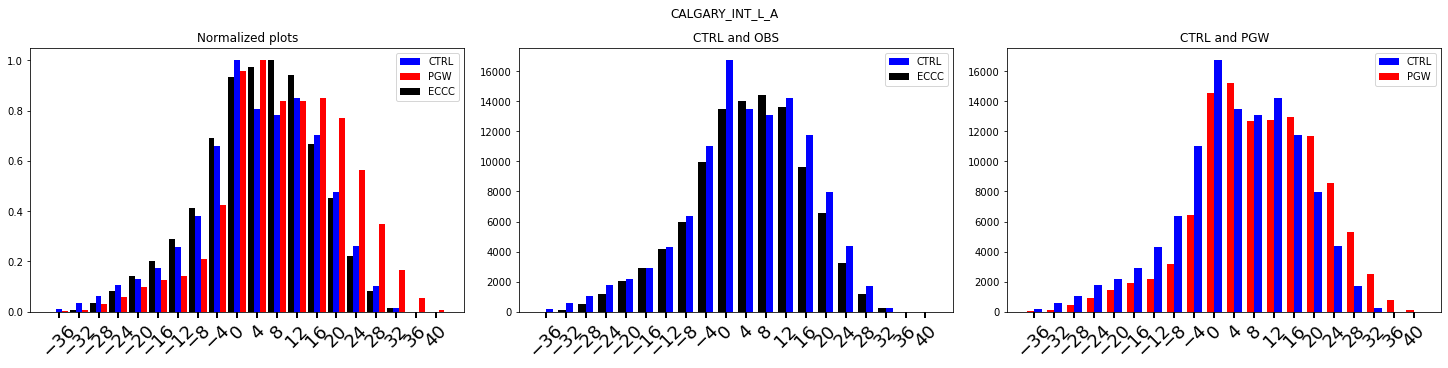

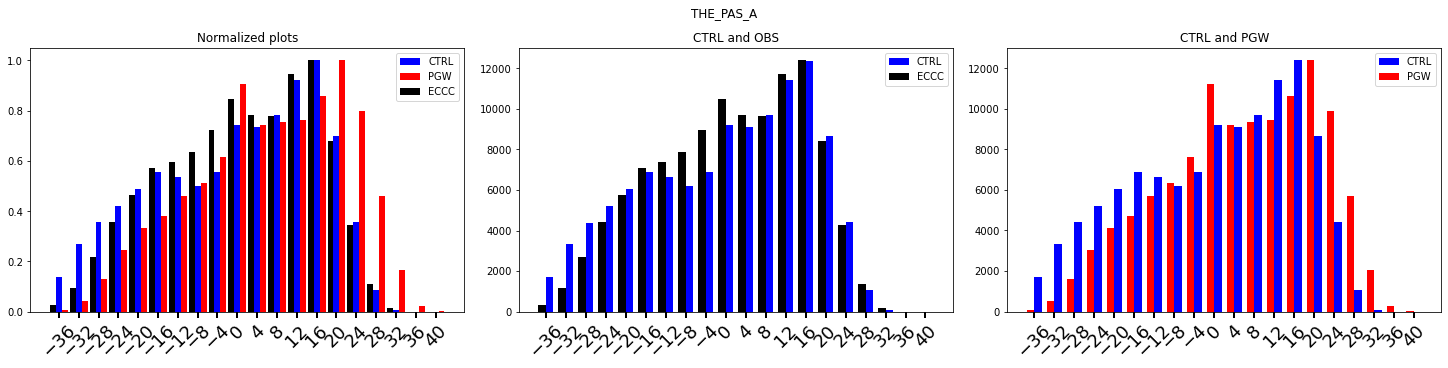

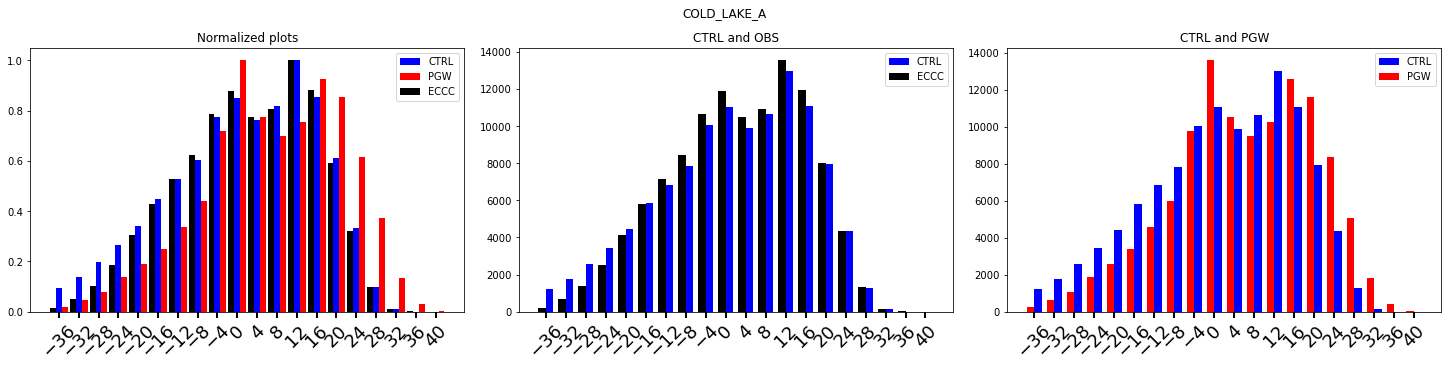

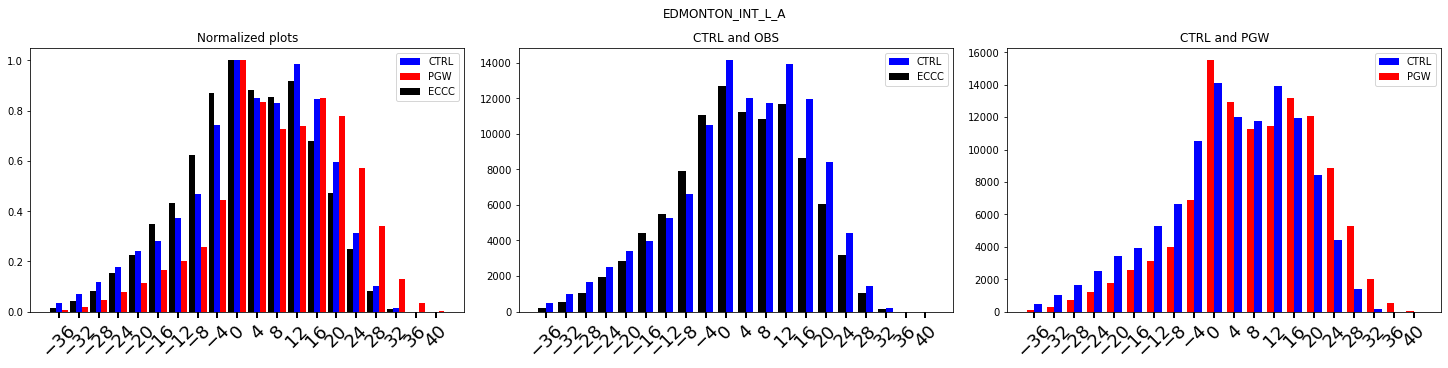

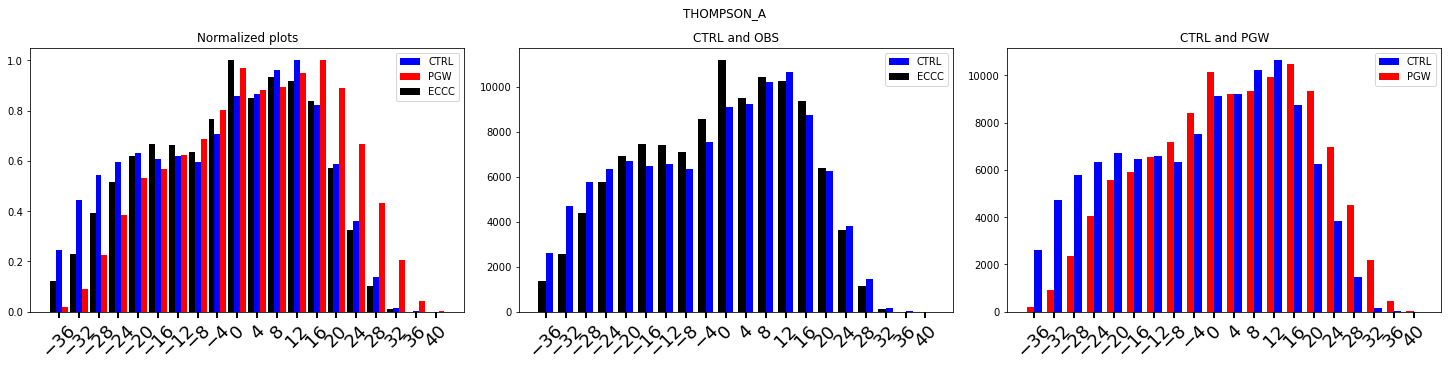

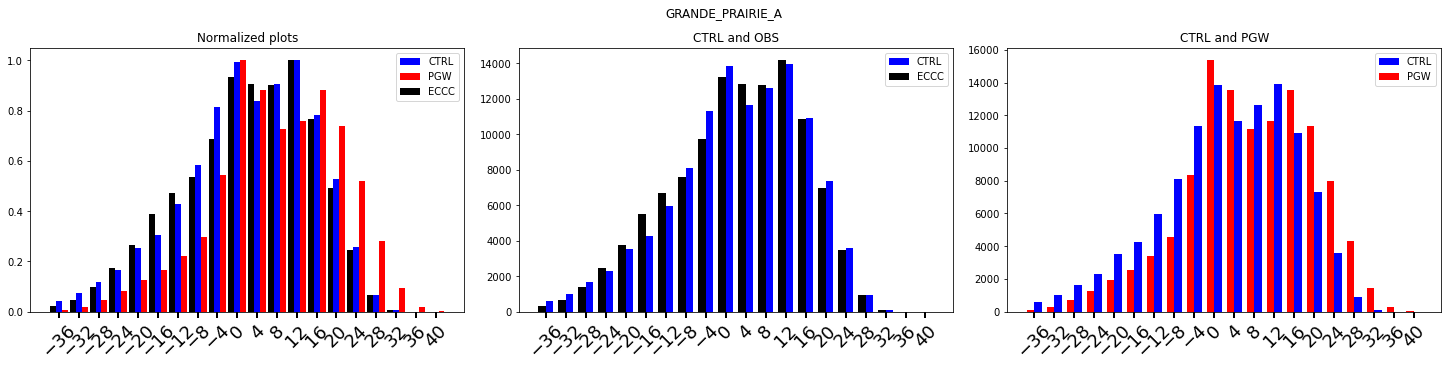

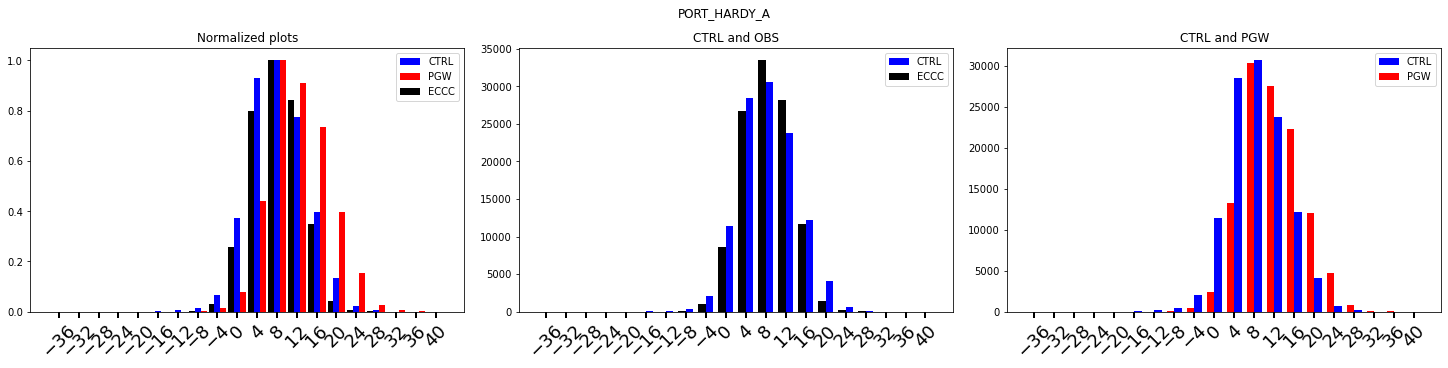

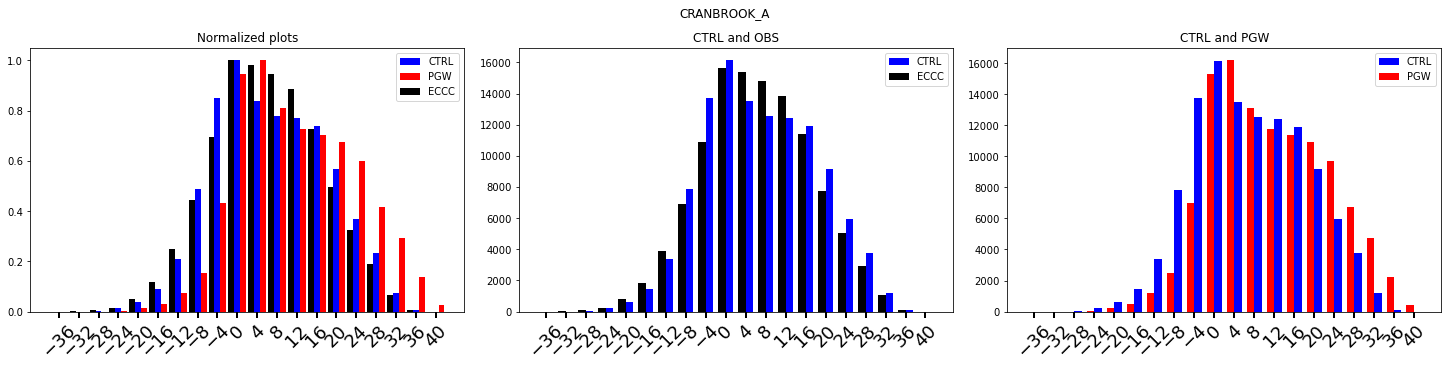

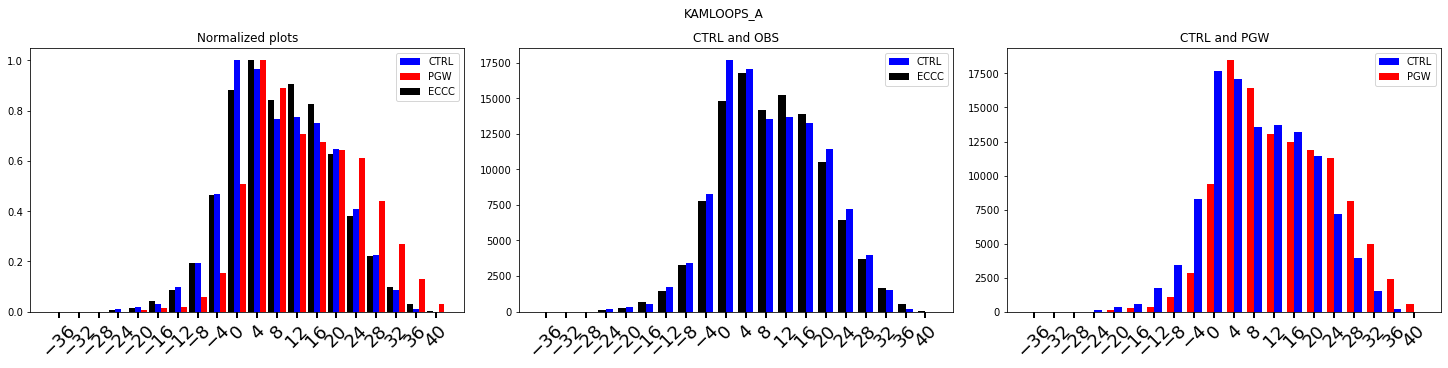

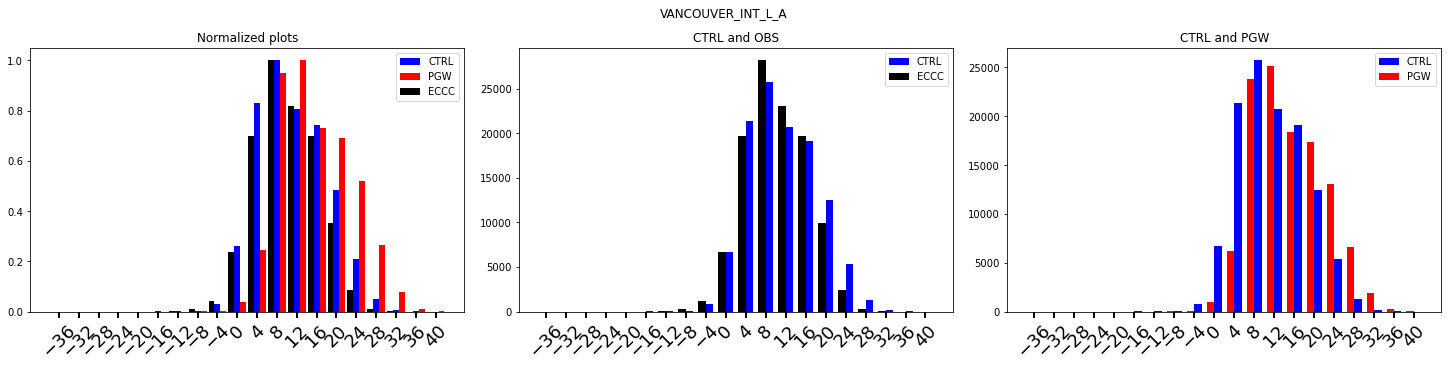

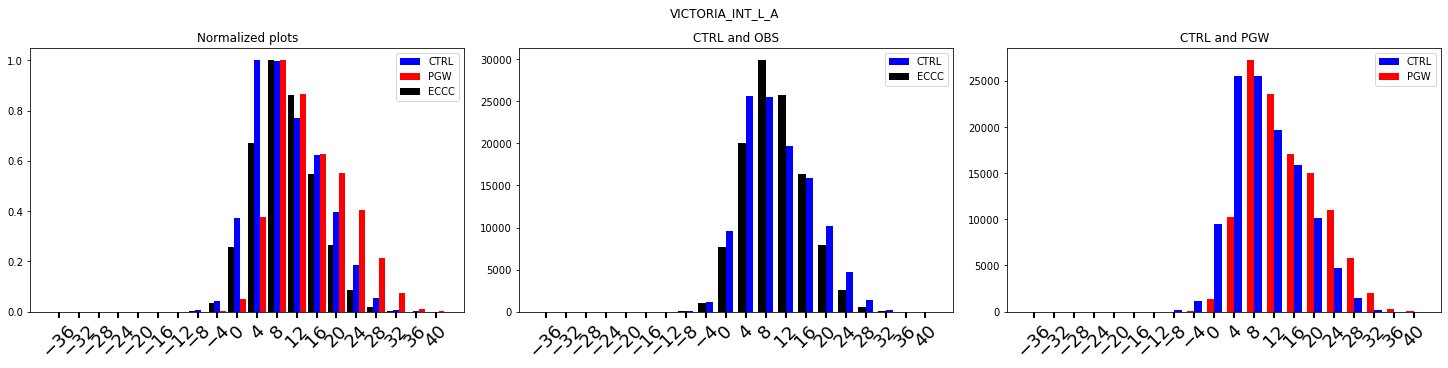

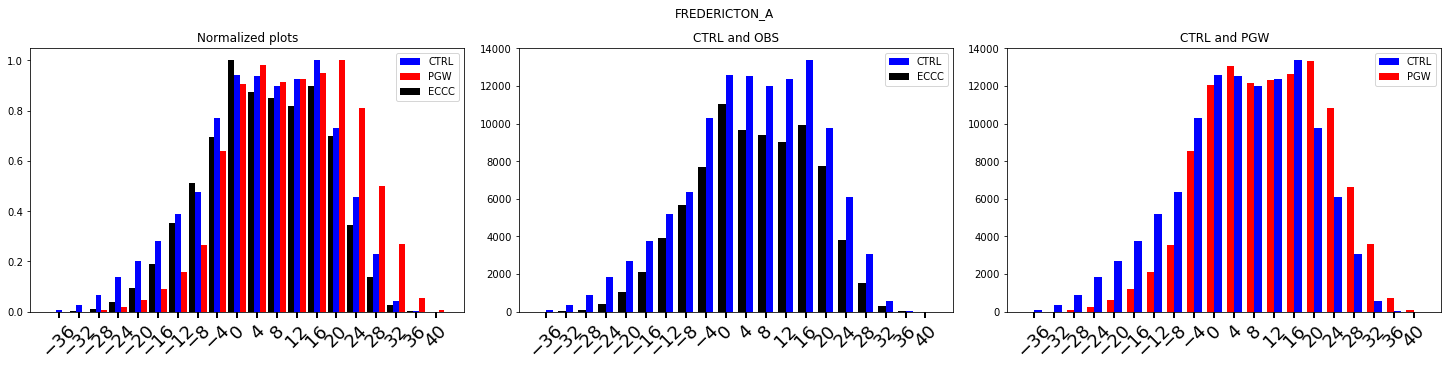

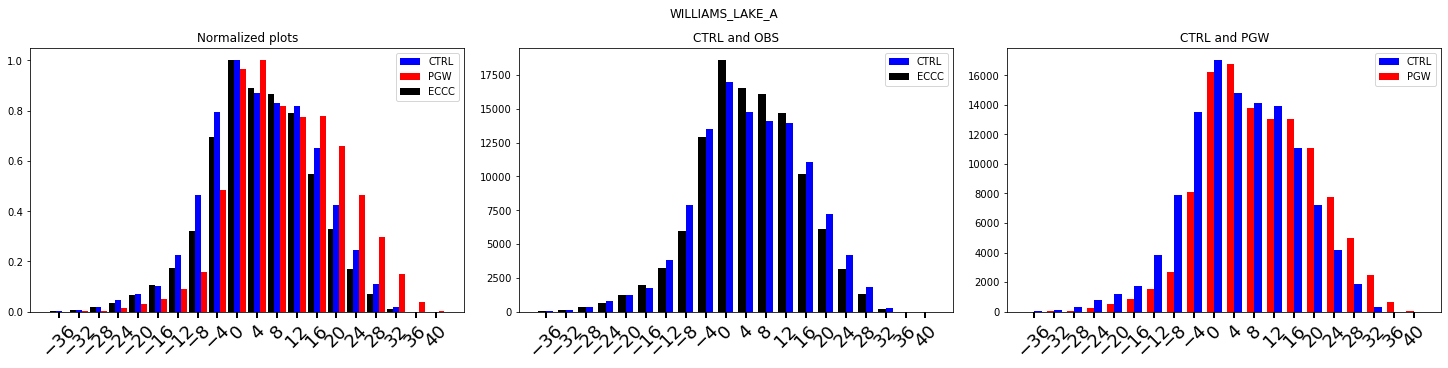

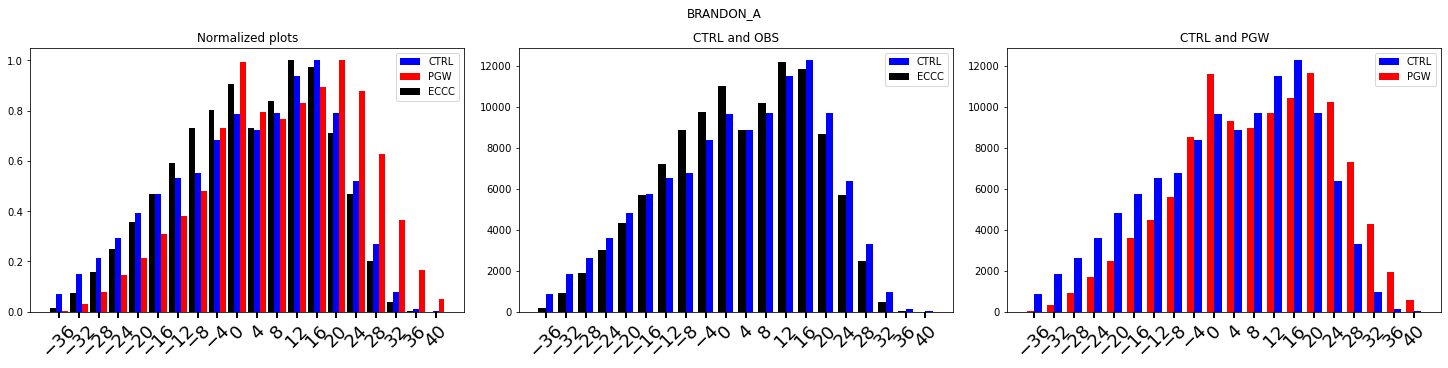

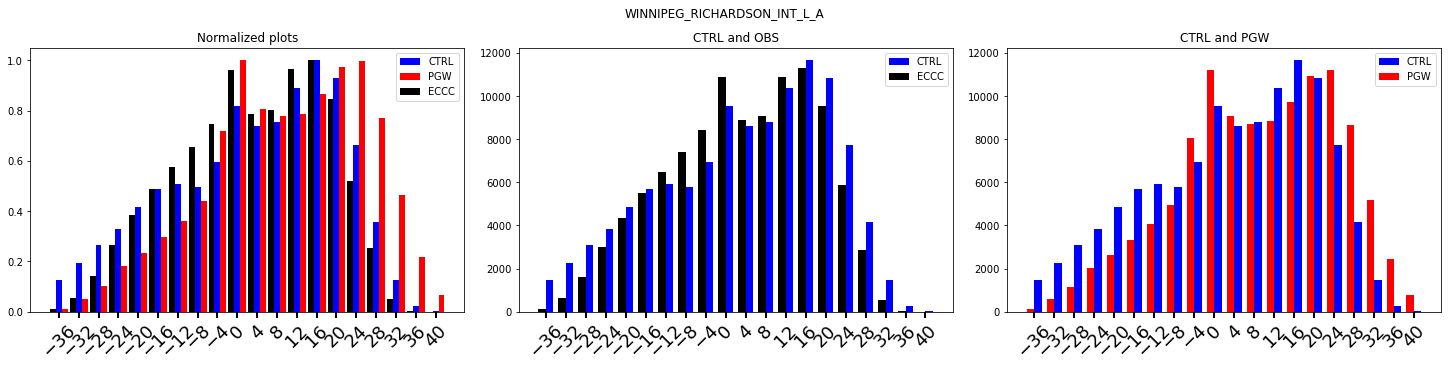

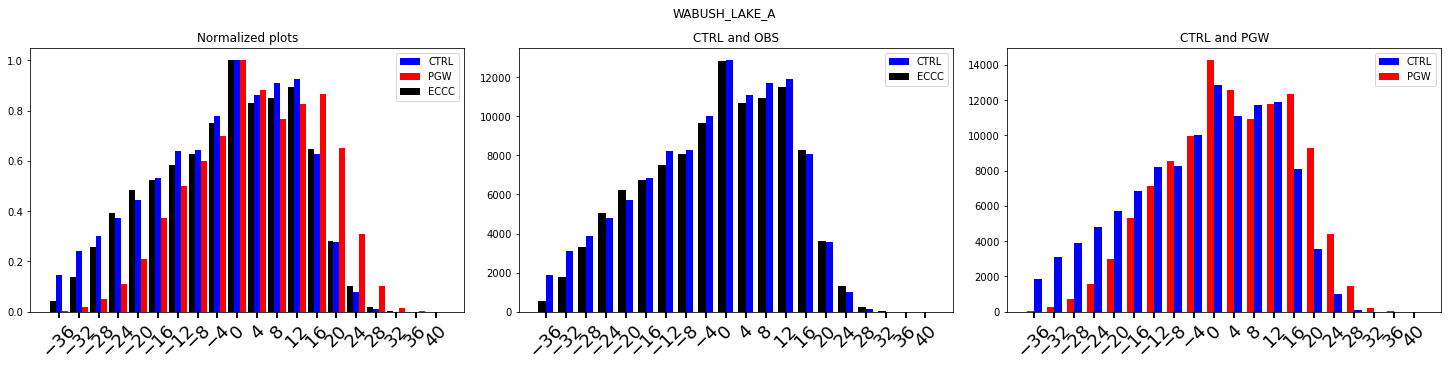

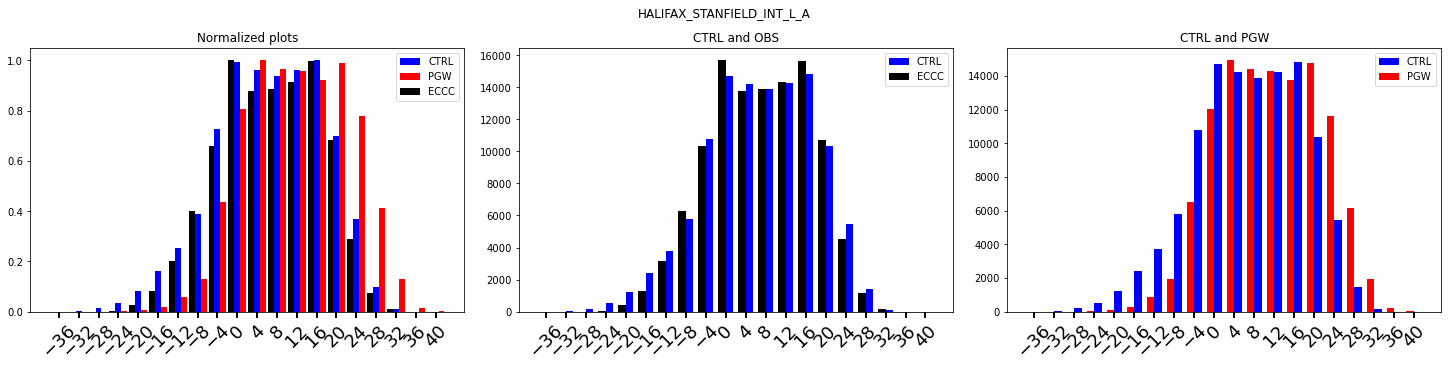

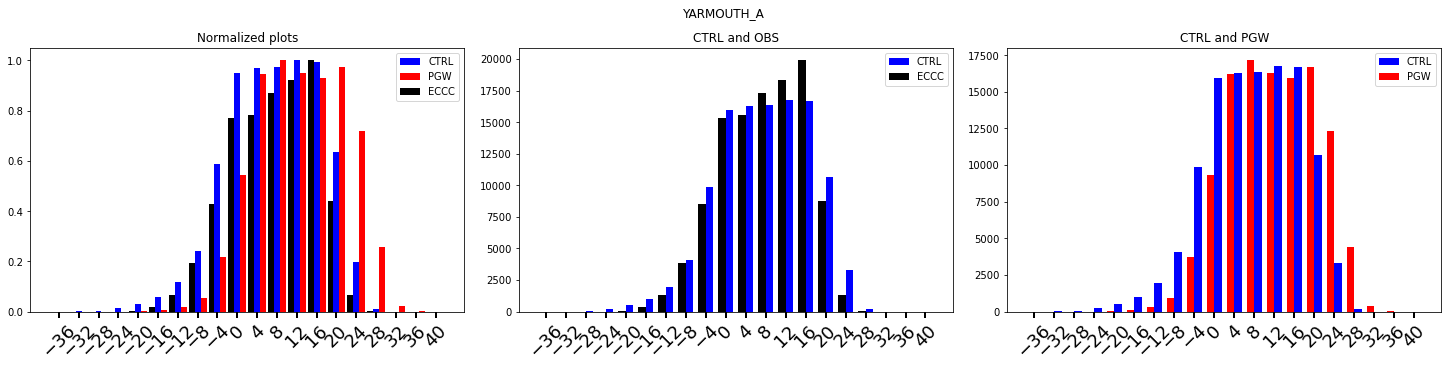

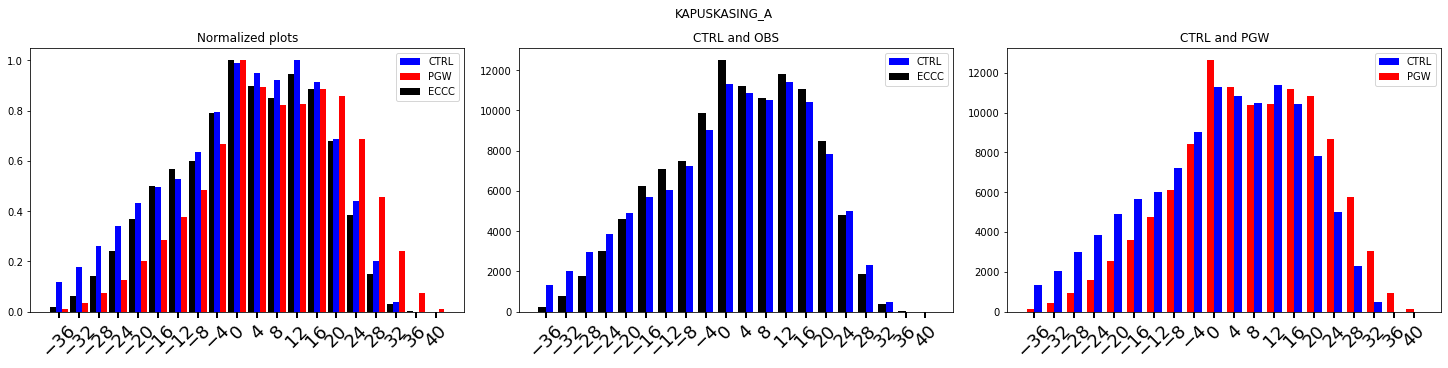

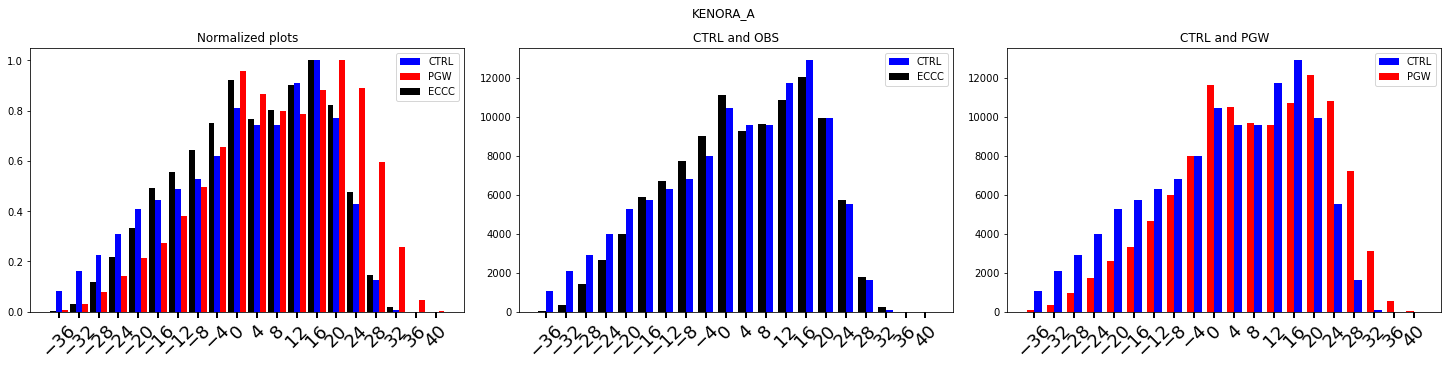

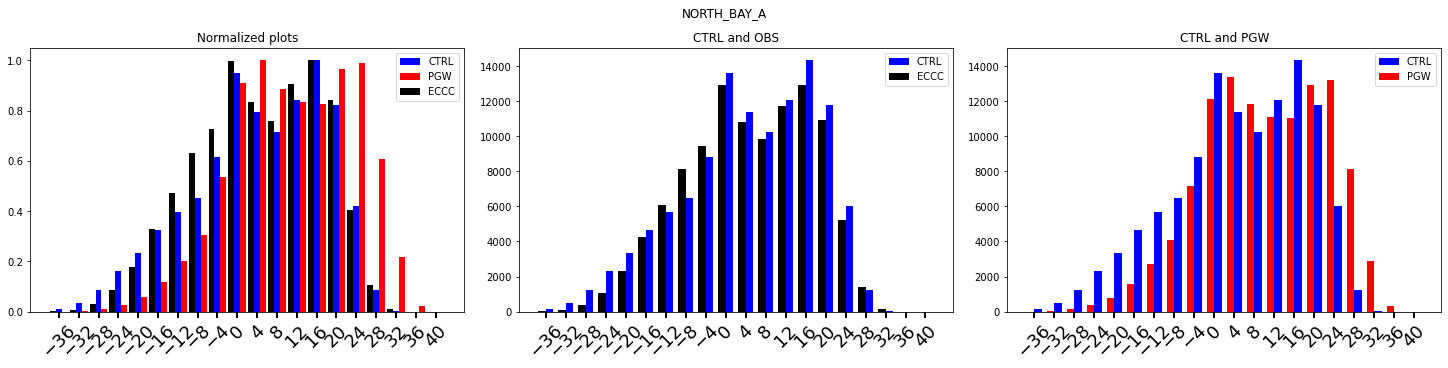

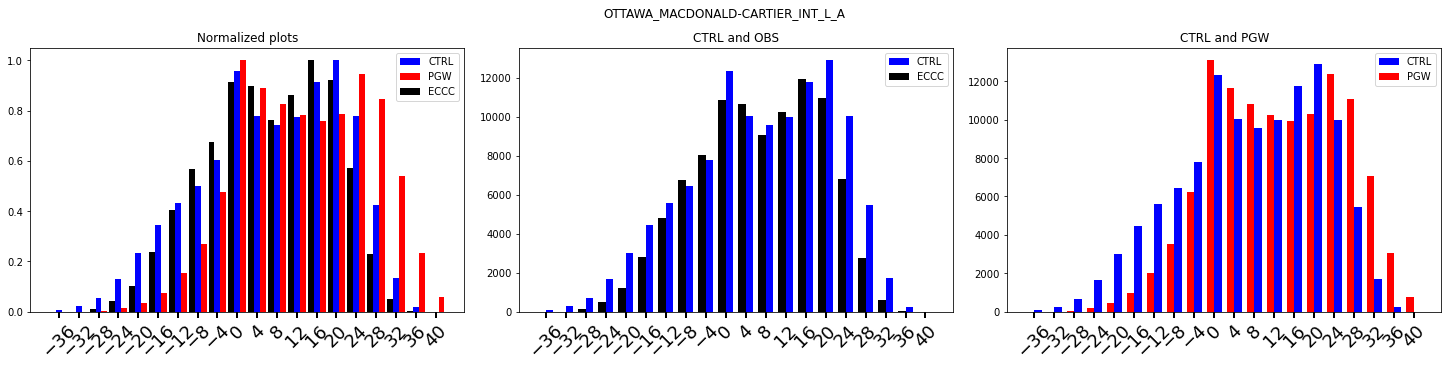

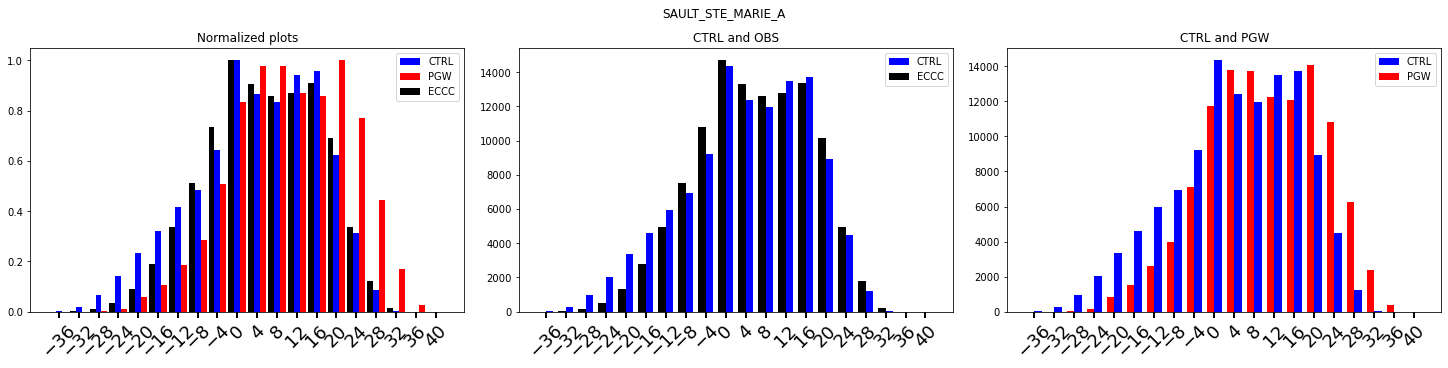

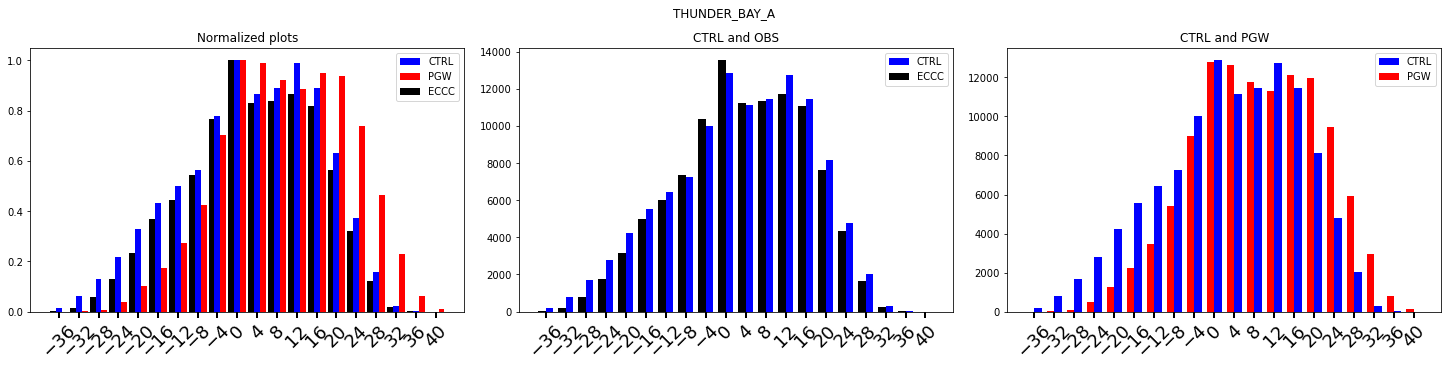

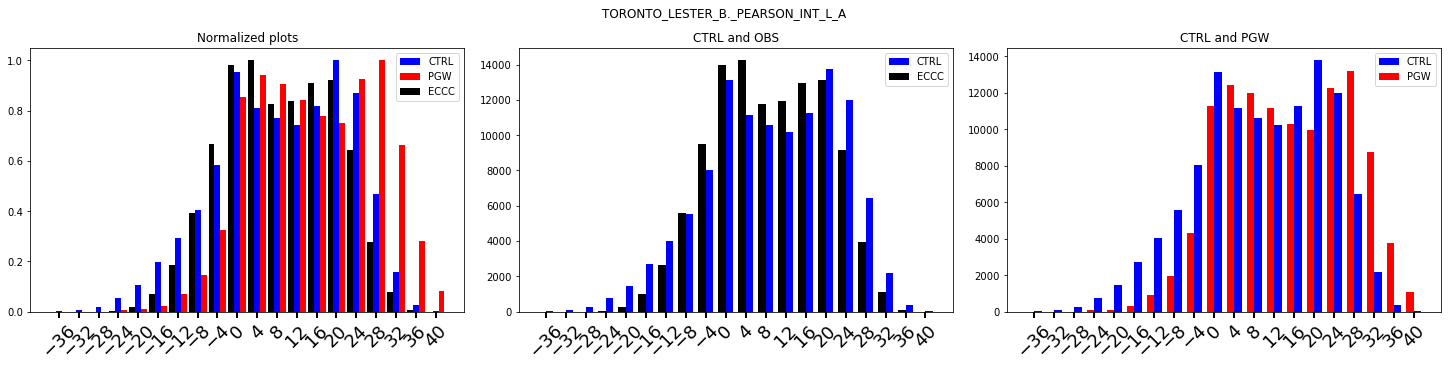

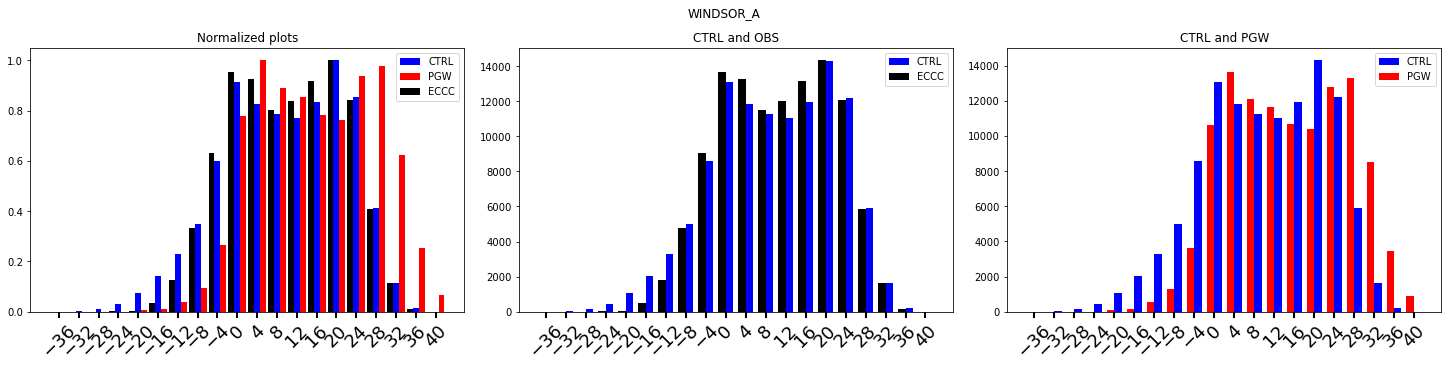

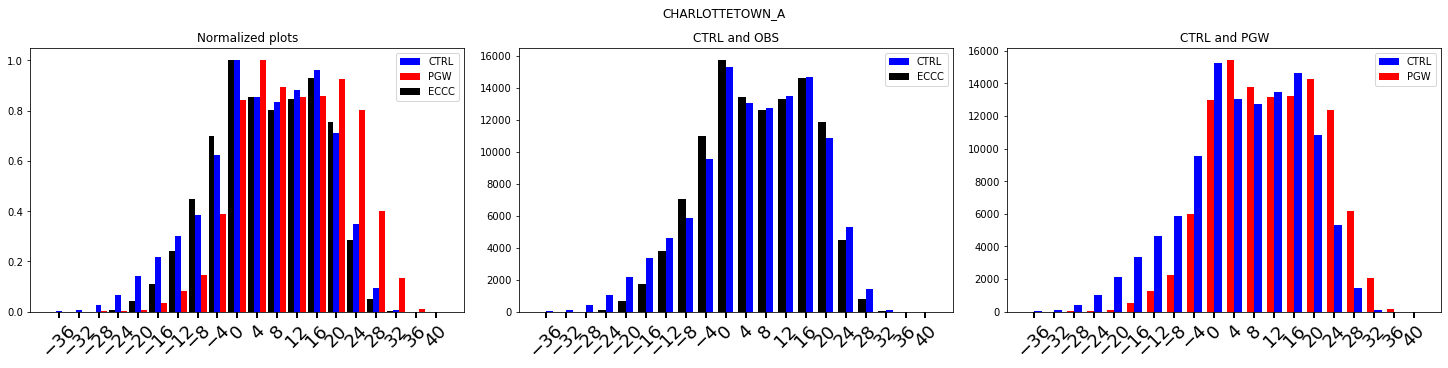

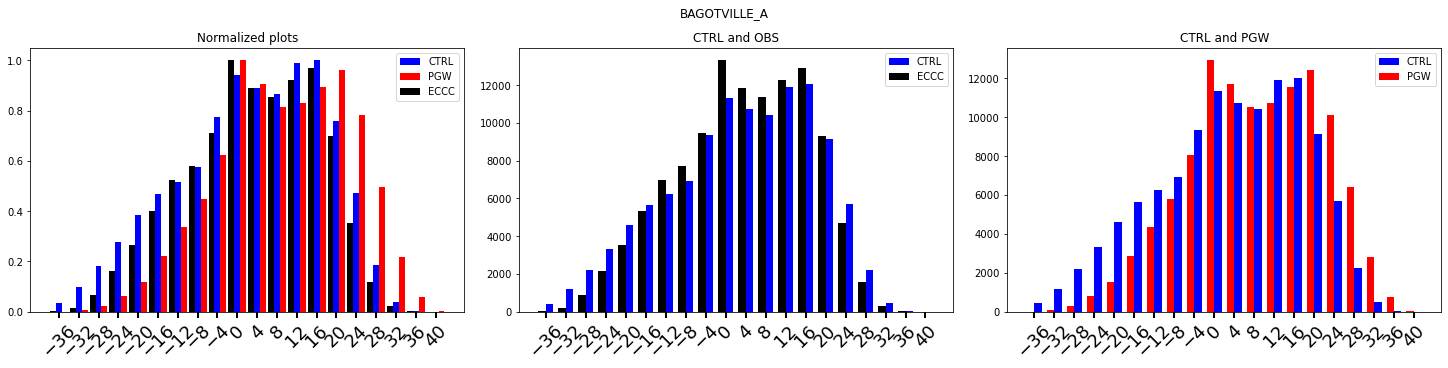

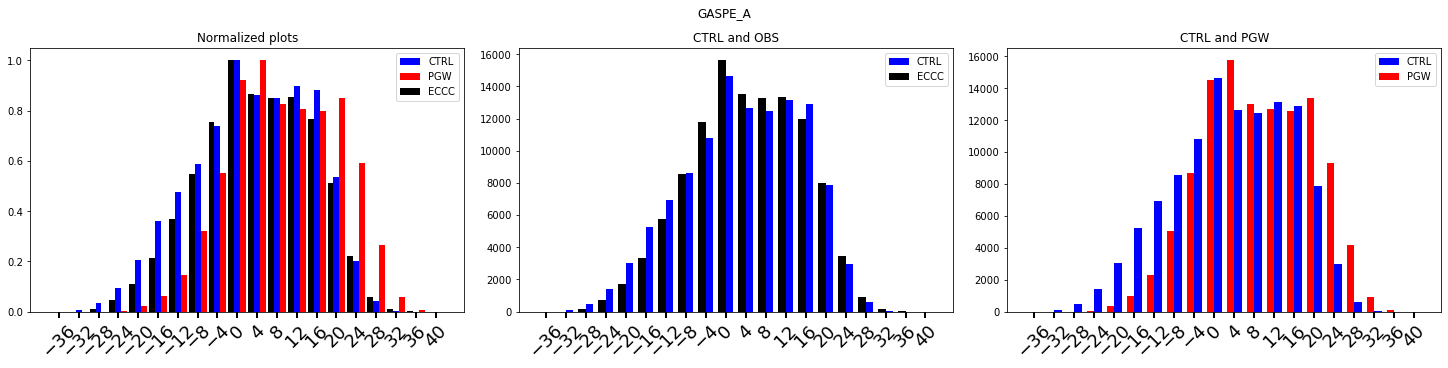

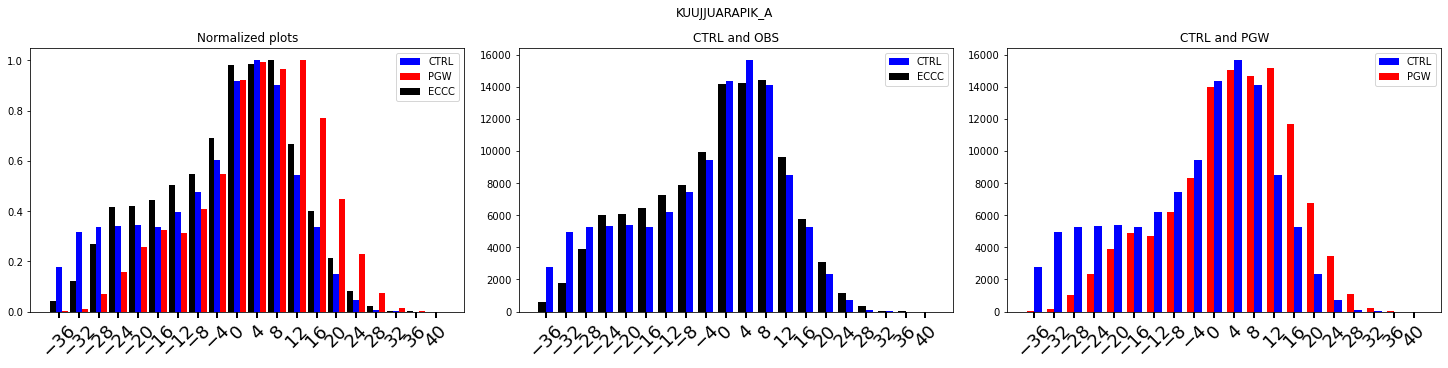

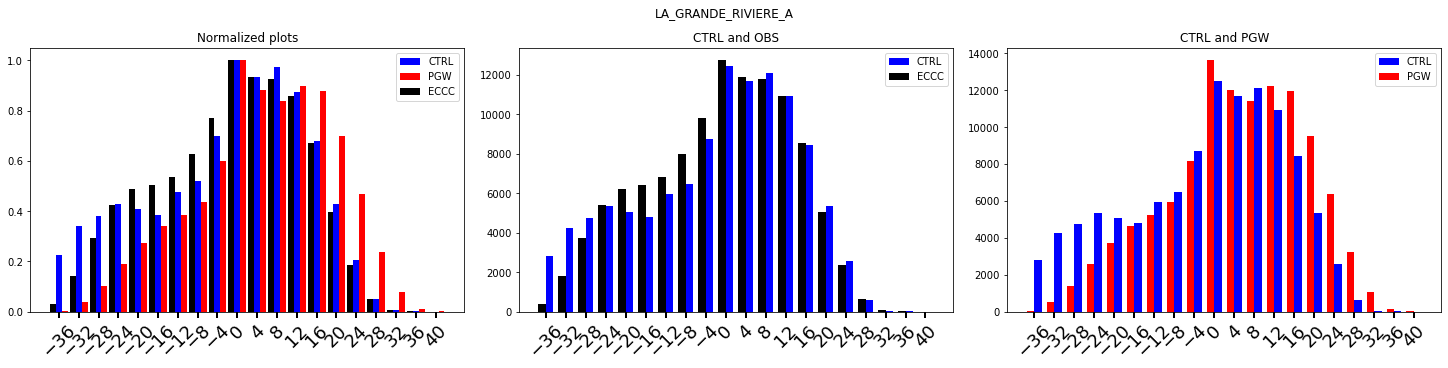

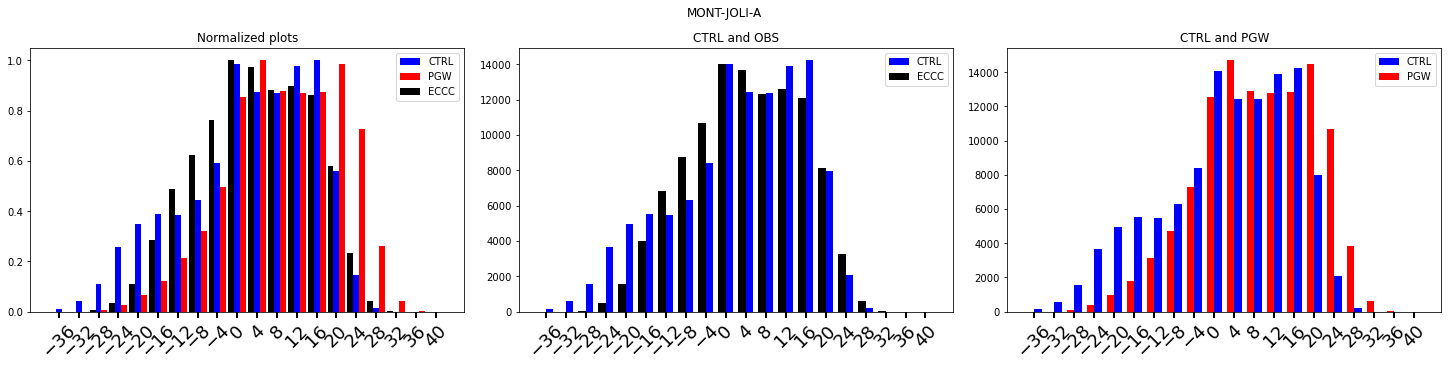

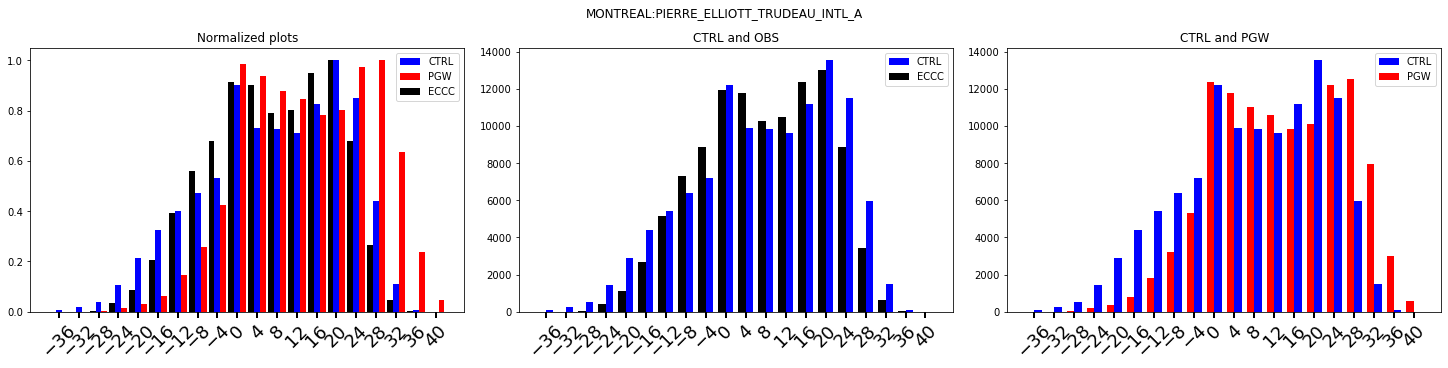

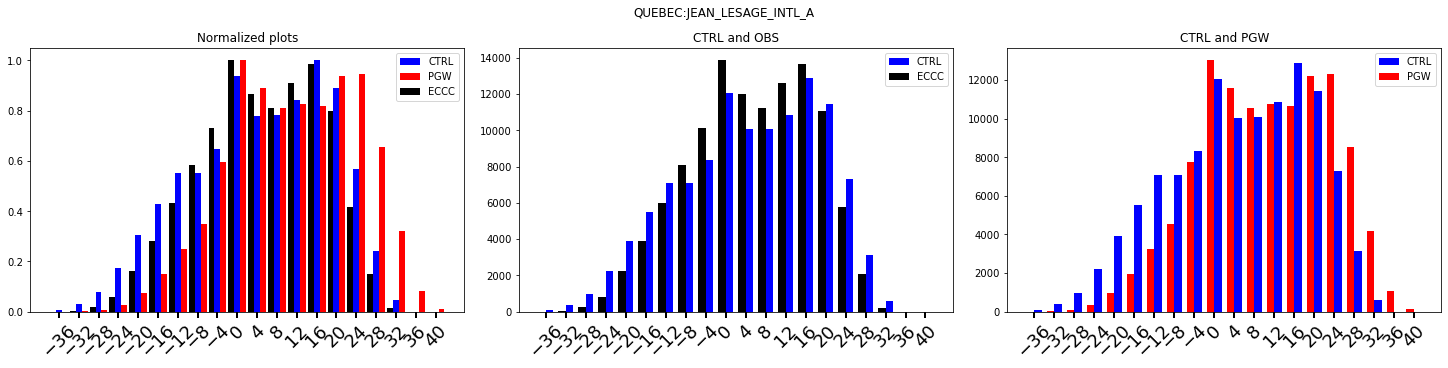

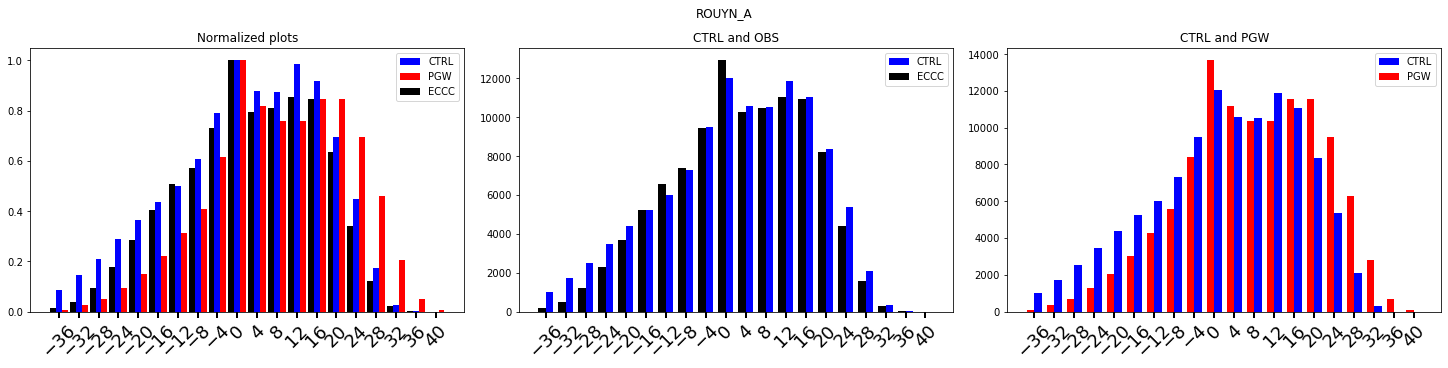

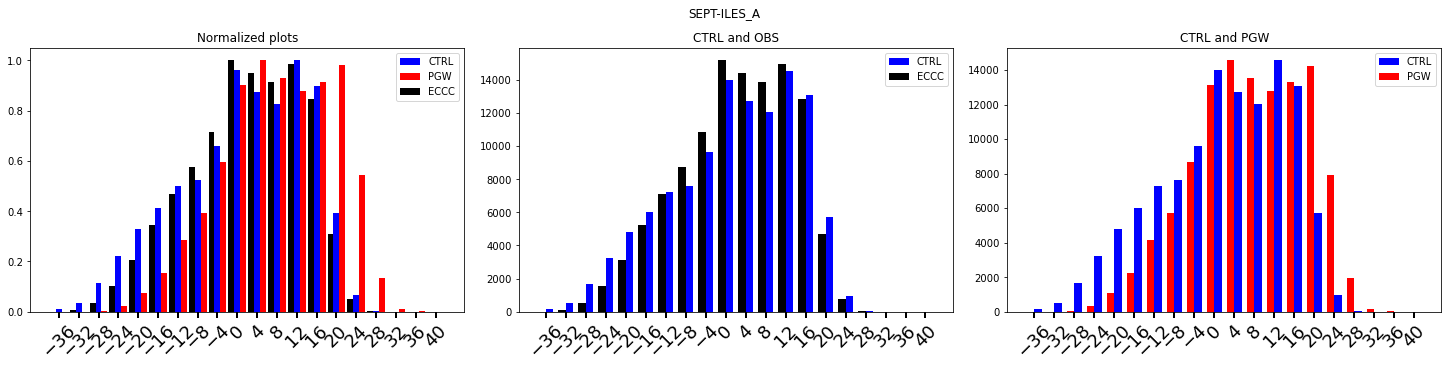

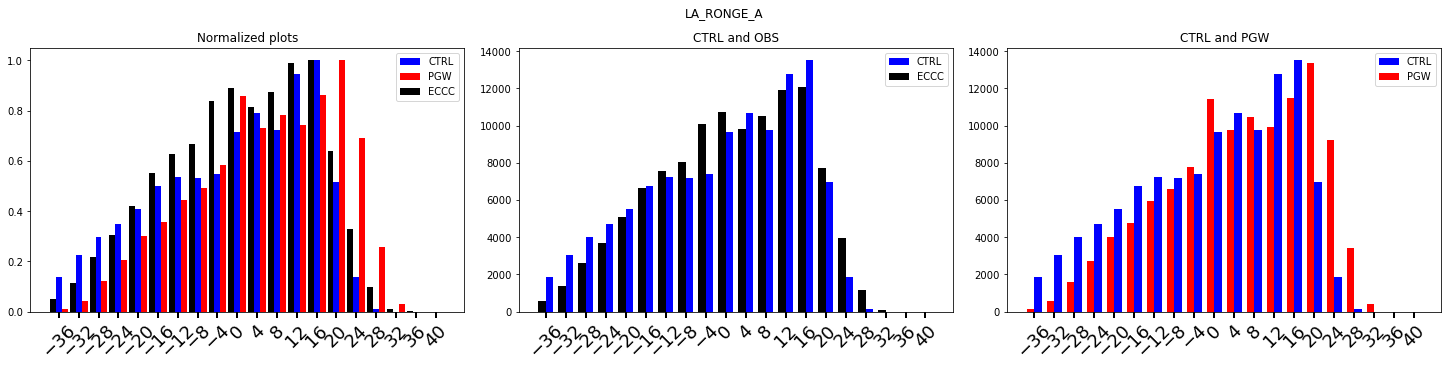

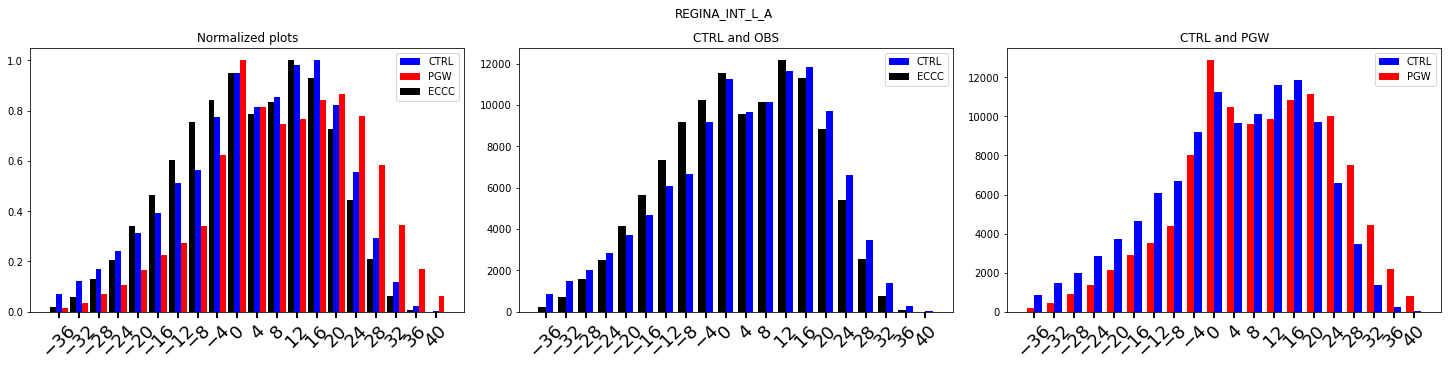

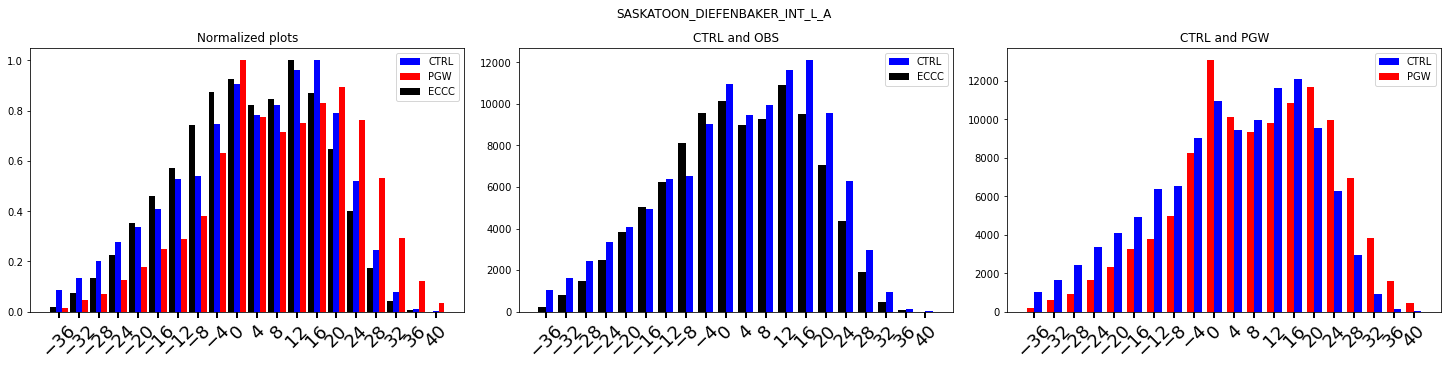

In [22]:
# Plotting the distribution
f = '/home/cruman/Scripts/EventDistributionT2M/CSV_ECCC'
#provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']
provinces = next(os.walk(f'{f}'))[1]
datei = datetime(2000,10,1,0)
datef = datetime(2013,9,30,23)

model = '/home/cruman/Scripts/EventDistributionT2M/CSV'
filenames = next(os.walk(f), (None, None, []))[2]

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

#f_csv = glob(f'{f}/*csv')
for i, c in enumerate(filenames):
    print(i, c)
    df_eccc = pd.read_csv(f'{f}/{c}', index_col=0)        

    # do the distribution of Temp
    dist = calcDist(df_eccc['Temp (°C)'].to_numpy())
    n_dist = dist/(np.max(dist))
    
    #mask = (df['Date/Time (LST)'] >= datei) & (df['Date/Time (LST)'] <= datef)
    #df = df.loc[mask]

    # Read the model data from the csv
    model_file = glob(f'{model}/{c[:5]}*CTRL*csv'.replace(' ', '_'))[0]
    df_m = pd.read_csv(model_file, index_col=0)
    df_m['Time'] = pd.to_datetime(df_m['Time'])
    mask2 = (df_m['Time'] > datei) & (df_m['Time'] <= datef)
    df_m = df_m[mask2]
    df_m['T2 (C)'] = df_m['T2 (K)'] - 273.15
    
    dist_ctrl = calcDist(df_m['T2 (C)'].to_numpy())
    n_dist_ctrl = dist_ctrl/(np.max(dist_ctrl))
    
    model_file_pgw = glob(f'{model}/{c[:5]}*PGW*csv'.replace(' ', '_'))[0]
    df_pgw = pd.read_csv(model_file_pgw, index_col=0)
    df_pgw['Time'] = pd.to_datetime(df_pgw['Time'])
    mask3 = (df_pgw['Time'] > datei) & (df_pgw['Time'] <= datef)
    df_pgw = df_pgw[mask3]
    df_pgw['T2 (C)'] = df_pgw['T2 (K)'] - 273.15
    
    dist_pgw = calcDist(df_pgw['T2 (C)'].to_numpy())
    n_dist_pgw = dist_pgw/(np.max(dist_pgw))
    
    # Plot and calculate the distribution
    #b = i%9
    #if b == 0:
        # savefig and create new plot object
       # if (i != 0):
       #     name = int(i/3)
       #     plt.savefig(f'distribution_{name}.png')
       #     plt.close()
       # if i == 36:
       #     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 5), constrained_layout=True)
       # else:
       #     fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(21, 16), constrained_layout=True)
       # 
        #axs = axs.flatten()
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), constrained_layout=True)
    l = np.arange(-50,48,4)-2
    ax[0].bar(l[4:-1], n_dist_ctrl[4:-1], color='blue', width=1.2, label='CTRL')
    ax[0].bar(l[4:-1]+1.2, n_dist_pgw[4:-1], color='red', width=1.2, label='PGW')
    ax[0].bar(l[4:-1]-1.2, n_dist[4:-1], color='black', width=1.2, label='ECCC')
    ax[0].legend()
    ax[0].set_title('Normalized plots')
    ax[0].set_xticks(l[4:-1])
    ax[0].tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=18)
    
    ax[1].bar(l[4:-1]+0.75, dist_ctrl[4:-1], color='blue', width=1.5, label='CTRL')    
    ax[1].bar(l[4:-1]-0.75, dist[4:-1], color='black', width=1.5, label='ECCC')
    ax[1].legend()
    ax[1].set_title('CTRL and OBS')
    ax[1].set_xticks(l[4:-1])
    ax[1].tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=18)
    
    ax[2].bar(l[4:-1]+0.75, dist_ctrl[4:-1], color='blue', width=1.5, label='CTRL')
    ax[2].bar(l[4:-1]-0.75, dist_pgw[4:-1], color='red', width=1.5, label='PGW')    
    ax[2].legend()
    ax[2].set_title('CTRL and PGW')
    ax[2].set_xticks(l[4:-1])
    ax[2].tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=18)
    
    #plt.tight_layout()
    plt.suptitle(c[:-4])
    plt.savefig(f'PNG_Dist/{c[:-4]}_3plots.png', facecolor='white')
    
    
    #plt.show()
    #sys.exit()
    
#name = int(i/3)
#plt.savefig(f'distribution_{name}.png')

    

    

0 CALGARY_INT_L_A.csv
1 THE_PAS_A.csv
2 COLD_LAKE_A.csv
3 EDMONTON_INT_L_A.csv
4 THOMPSON_A.csv
5 GRANDE_PRAIRIE_A.csv
6 PORT_HARDY_A.csv
7 CRANBROOK_A.csv
8 KAMLOOPS_A.csv
9 VANCOUVER_INT_L_A.csv
10 VICTORIA_INT_L_A.csv
11 FREDERICTON_A.csv
12 WILLIAMS_LAKE_A.csv
13 BRANDON_A.csv
14 WINNIPEG_RICHARDSON_INT_L_A.csv
15 WABUSH_LAKE_A.csv
16 HALIFAX_STANFIELD_INT_L_A.csv
17 YARMOUTH_A.csv
18 KAPUSKASING_A.csv
19 KENORA_A.csv
20 NORTH_BAY_A.csv
21 OTTAWA_MACDONALD-CARTIER_INT_L_A.csv
22 SAULT_STE_MARIE_A.csv
23 THUNDER_BAY_A.csv
24 TORONTO_LESTER_B._PEARSON_INT_L_A.csv
25 WINDSOR_A.csv
26 CHARLOTTETOWN_A.csv
27 BAGOTVILLE_A.csv
28 GASPE_A.csv
29 KUUJJUARAPIK_A.csv
30 LA_GRANDE_RIVIERE_A.csv
31 MONT-JOLI-A.csv
32 MONTREAL:PIERRE_ELLIOTT_TRUDEAU_INTL_A.csv
33 QUEBEC:JEAN_LESAGE_INTL_A.csv
34 ROUYN_A.csv
35 SEPT-ILES_A.csv
36 LA_RONGE_A.csv
37 REGINA_INT_L_A.csv
38 SASKATOON_DIEFENBAKER_INT_L_A.csv


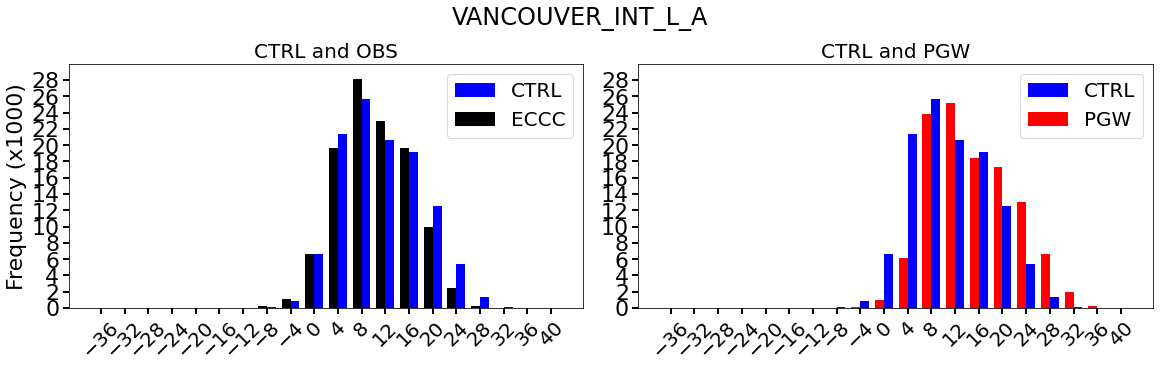

In [44]:
# Plotting the distribution
f = '/home/cruman/Scripts/EventDistributionT2M/CSV_ECCC'
#provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']
provinces = next(os.walk(f'{f}'))[1]
datei = datetime(2000,10,1,0)
datef = datetime(2013,9,30,23)

model = '/home/cruman/Scripts/EventDistributionT2M/CSV'
filenames = next(os.walk(f), (None, None, []))[2]

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

#f_csv = glob(f'{f}/*csv')
for i, c in enumerate(filenames):
    print(i, c)
    if 'VANC' in c:
        df_eccc = pd.read_csv(f'{f}/{c}', index_col=0)        

        # do the distribution of Temp
        dist = calcDist(df_eccc['Temp (°C)'].to_numpy())
        n_dist = dist/(np.max(dist))

        #mask = (df['Date/Time (LST)'] >= datei) & (df['Date/Time (LST)'] <= datef)
        #df = df.loc[mask]

        # Read the model data from the csv
        model_file = glob(f'{model}/{c[:5]}*CTRL*csv'.replace(' ', '_'))[0]
        df_m = pd.read_csv(model_file, index_col=0)
        df_m['Time'] = pd.to_datetime(df_m['Time'])
        mask2 = (df_m['Time'] > datei) & (df_m['Time'] <= datef)
        df_m = df_m[mask2]
        df_m['T2 (C)'] = df_m['T2 (K)'] - 273.15

        dist_ctrl = calcDist(df_m['T2 (C)'].to_numpy())
        n_dist_ctrl = dist_ctrl/(np.max(dist_ctrl))

        model_file_pgw = glob(f'{model}/{c[:5]}*PGW*csv'.replace(' ', '_'))[0]
        df_pgw = pd.read_csv(model_file_pgw, index_col=0)
        df_pgw['Time'] = pd.to_datetime(df_pgw['Time'])
        mask3 = (df_pgw['Time'] > datei) & (df_pgw['Time'] <= datef)
        df_pgw = df_pgw[mask3]
        df_pgw['T2 (C)'] = df_pgw['T2 (K)'] - 273.15

        dist_pgw = calcDist(df_pgw['T2 (C)'].to_numpy())
        n_dist_pgw = dist_pgw/(np.max(dist_pgw))

        # Plot and calculate the distribution
        #b = i%9
        #if b == 0:
            # savefig and create new plot object
           # if (i != 0):
           #     name = int(i/3)
           #     plt.savefig(f'distribution_{name}.png')
           #     plt.close()
           # if i == 36:
           #     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 5), constrained_layout=True)
           # else:
           #     fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(21, 16), constrained_layout=True)
           # 
            #axs = axs.flatten()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), constrained_layout=True)
        l = np.arange(-50,48,4)-2

        ax[0].bar(l[4:-1]+0.75, dist_ctrl[4:-1], color='blue', width=1.5, label='CTRL')    
        ax[0].bar(l[4:-1]-0.75, dist[4:-1], color='black', width=1.5, label='ECCC')
        ax[0].legend(fontsize=20)
        ax[0].set_title('CTRL and OBS', fontsize=20)
        ax[0].set_xticks(l[4:-1])
        #ax[0].set_yticks(np.arange(0,18000,2000))
        ax[0].set_yticks(np.arange(0,30000,2000))
        ax[0].set_ylim(0,30000)
        ax[0].set_ylabel('Frequency (x1000)', fontsize=22)
        #a=ax[0].get_yticks().tolist()
        #print(a)
        #ax[0].set_yticklabels(['0', '2K', '4K', '6K', '8K', '10K', '12K', '14K', '16K'])
        #ax[0].set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'])
        ax[0].set_yticklabels(np.arange(0,30,2))
        ax[0].tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=20)
        ax[0].tick_params(axis='y', direction='out', length=6, width=2, labelsize=22)

        ax[1].bar(l[4:-1]+0.75, dist_ctrl[4:-1], color='blue', width=1.5, label='CTRL')
        ax[1].bar(l[4:-1]-0.75, dist_pgw[4:-1], color='red', width=1.5, label='PGW')    
        ax[1].legend(fontsize=20)
        ax[1].set_title('CTRL and PGW', fontsize=20)
        ax[1].set_xticks(l[4:-1])
        #ax[1].set_yticks(np.arange(0,18000,2000))
        ax[1].set_yticks(np.arange(0,30000,2000))
        ax[1].set_ylim(0,30000)
        #ax[1].set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'])
        ax[1].set_yticklabels(np.arange(0,30,2))
        ax[1].tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=20)
        ax[1].tick_params(axis='y', direction='out', length=6, width=2, labelsize=22)


        #plt.tight_layout()
        plt.suptitle(c[:-4], fontsize=24)
        plt.savefig(f'PNG_Dist/{c[:-4]}_2plots.png', facecolor='white', bbox_inches='tight')
    
    
    #plt.show()
    #sys.exit()
    
#name = int(i/3)
#plt.savefig(f'distribution_{name}.png')

    

    

0 CALGARY_INT_L_A.csv
1 THE_PAS_A.csv
2 COLD_LAKE_A.csv
3 EDMONTON_INT_L_A.csv
4 THOMPSON_A.csv
5 GRANDE_PRAIRIE_A.csv
6 PORT_HARDY_A.csv
7 CRANBROOK_A.csv
8 KAMLOOPS_A.csv
9 VANCOUVER_INT_L_A.csv
10 VICTORIA_INT_L_A.csv
11 FREDERICTON_A.csv
12 WILLIAMS_LAKE_A.csv
13 BRANDON_A.csv
14 WINNIPEG_RICHARDSON_INT_L_A.csv
15 WABUSH_LAKE_A.csv
16 HALIFAX_STANFIELD_INT_L_A.csv
17 YARMOUTH_A.csv
18 KAPUSKASING_A.csv
19 KENORA_A.csv
20 NORTH_BAY_A.csv
21 OTTAWA_MACDONALD-CARTIER_INT_L_A.csv
22 SAULT_STE_MARIE_A.csv
23 THUNDER_BAY_A.csv
24 TORONTO_LESTER_B._PEARSON_INT_L_A.csv
25 WINDSOR_A.csv
26 CHARLOTTETOWN_A.csv
27 BAGOTVILLE_A.csv
28 GASPE_A.csv
29 KUUJJUARAPIK_A.csv
30 LA_GRANDE_RIVIERE_A.csv
31 MONT-JOLI-A.csv
32 MONTREAL:PIERRE_ELLIOTT_TRUDEAU_INTL_A.csv
33 QUEBEC:JEAN_LESAGE_INTL_A.csv
34 ROUYN_A.csv
35 SEPT-ILES_A.csv
36 LA_RONGE_A.csv
37 REGINA_INT_L_A.csv
38 SASKATOON_DIEFENBAKER_INT_L_A.csv


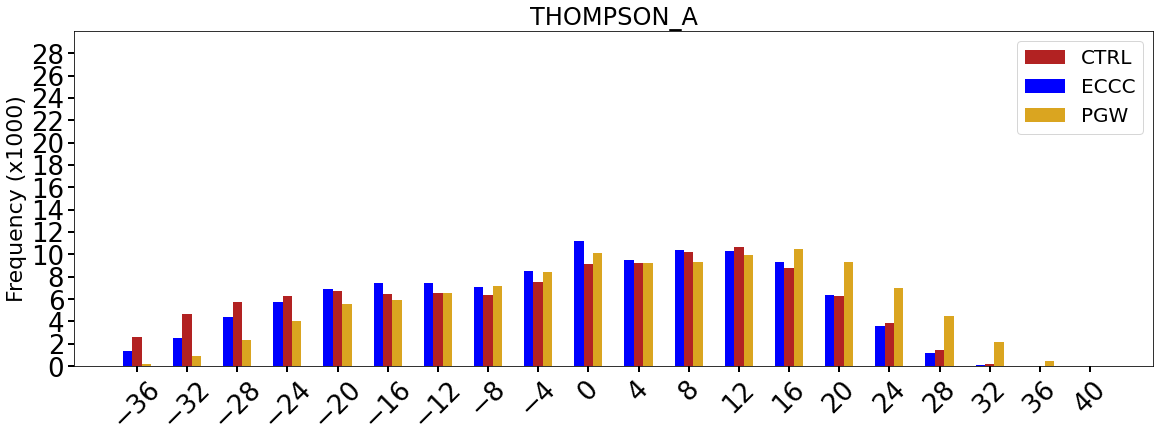

In [28]:
# Plotting the distribution, the 3 together
f = '/home/cruman/Scripts/EventDistributionT2M/CSV_ECCC'
#provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']
provinces = next(os.walk(f'{f}'))[1]
datei = datetime(2000,10,1,0)
datef = datetime(2013,9,30,23)

model = '/home/cruman/Scripts/EventDistributionT2M/CSV'
filenames = next(os.walk(f), (None, None, []))[2]

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

#f_csv = glob(f'{f}/*csv')
for i, c in enumerate(filenames):
    print(i, c)
    if 'THOMP' in c:
        df_eccc = pd.read_csv(f'{f}/{c}', index_col=0)        

        # do the distribution of Temp
        dist = calcDist(df_eccc['Temp (°C)'].to_numpy())
        n_dist = dist/(np.max(dist))

        #mask = (df['Date/Time (LST)'] >= datei) & (df['Date/Time (LST)'] <= datef)
        #df = df.loc[mask]

        # Read the model data from the csv
        model_file = glob(f'{model}/{c[:5]}*CTRL*csv'.replace(' ', '_'))[0]
        df_m = pd.read_csv(model_file, index_col=0)
        df_m['Time'] = pd.to_datetime(df_m['Time'])
        mask2 = (df_m['Time'] > datei) & (df_m['Time'] <= datef)
        df_m = df_m[mask2]
        df_m['T2 (C)'] = df_m['T2 (K)'] - 273.15

        dist_ctrl = calcDist(df_m['T2 (C)'].to_numpy())
        n_dist_ctrl = dist_ctrl/(np.max(dist_ctrl))

        model_file_pgw = glob(f'{model}/{c[:5]}*PGW*csv'.replace(' ', '_'))[0]
        df_pgw = pd.read_csv(model_file_pgw, index_col=0)
        df_pgw['Time'] = pd.to_datetime(df_pgw['Time'])
        mask3 = (df_pgw['Time'] > datei) & (df_pgw['Time'] <= datef)
        df_pgw = df_pgw[mask3]
        df_pgw['T2 (C)'] = df_pgw['T2 (K)'] - 273.15

        dist_pgw = calcDist(df_pgw['T2 (C)'].to_numpy())
        n_dist_pgw = dist_pgw/(np.max(dist_pgw))

        # Plot and calculate the distribution
        #b = i%9
        #if b == 0:
            # savefig and create new plot object
           # if (i != 0):
           #     name = int(i/3)
           #     plt.savefig(f'distribution_{name}.png')
           #     plt.close()
           # if i == 36:
           #     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 5), constrained_layout=True)
           # else:
           #     fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(21, 16), constrained_layout=True)
           # 
            #axs = axs.flatten()
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), constrained_layout=True)
        l = np.arange(-50,48,4)-2

        ax.bar(l[4:-1], dist_ctrl[4:-1], color='firebrick', width=0.75, label='CTRL')    
        ax.bar(l[4:-1]-0.75, dist[4:-1], color='blue', width=0.75, label='ECCC')
        ax.bar(l[4:-1]+0.75, dist_pgw[4:-1], color='goldenrod', width=0.75, label='PGW')    
        ax.legend(fontsize=20)
        ax.set_title(c[:-4], fontsize=24)
        ax.set_xticks(l[4:-1])
        #ax[0].set_yticks(np.arange(0,18000,2000))
        ax.set_yticks(np.arange(0,30000,2000))
        ax.set_ylim(0,30000)
        ax.set_ylabel('Frequency (x1000)', fontsize=22)
        #a=ax[0].get_yticks().tolist()
        #print(a)
        #ax[0].set_yticklabels(['0', '2K', '4K', '6K', '8K', '10K', '12K', '14K', '16K'])
        #a[0].set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'])
        ax.set_yticklabels(np.arange(0,30,2))
        ax.tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2, labelsize=26)
        ax.tick_params(axis='y', direction='out', length=6, width=2, labelsize=26)        

        #plt.tight_layout()
        #plt.suptitle(c[:-4], fontsize=24)
        plt.savefig(f'PNG_Dist/{c[:-4]}_3plots.png', facecolor='white', bbox_inches='tight')
    
    
    #plt.show()
    #sys.exit()
    
#name = int(i/3)
#plt.savefig(f'distribution_{name}.png')

    

    

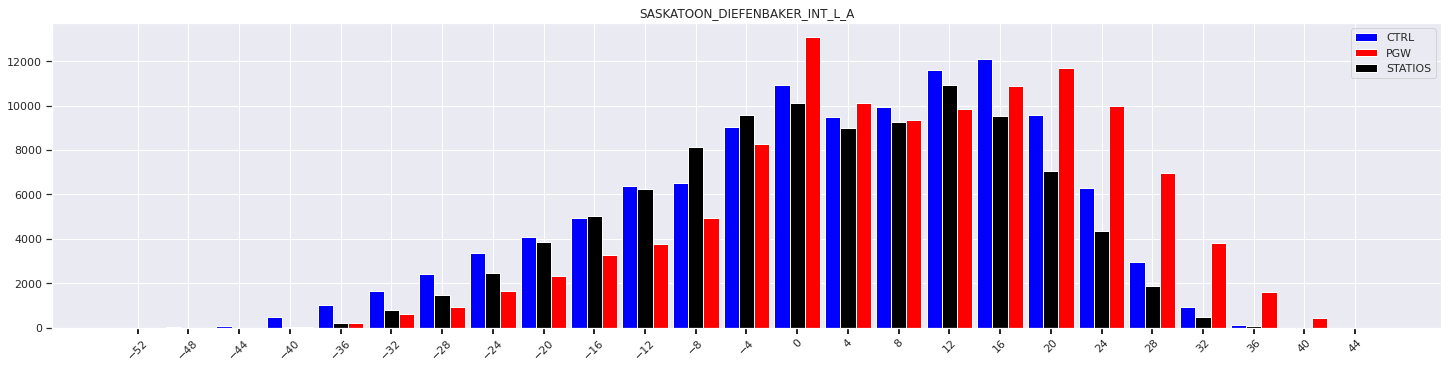

In [195]:
l = np.arange(-50,48,4)-2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(20,5))
ax.bar(l-1.2, dist_ctrl, color='blue', width=1.2, label='CTRL')
ax.bar(l+1.2, dist_pgw, color='red', width=1.2, label='PGW')
ax.bar(l, dist, color='black', width=1.2, label='STATIOS')
ax.legend()
ax.set_title(c[:-4])
ax.set_xticks(l)
ax.tick_params(axis='x', labelrotation=45, direction='out', length=6, width=2)


In [186]:
filenames

['CALGARY_INT_L_A.csv',
 'THE_PAS_A.csv',
 'COLD_LAKE_A.csv',
 'EDMONTON_INT_L_A.csv',
 'THOMPSON_A.csv',
 'GRANDE_PRAIRIE_A.csv',
 'PORT_HARDY_A.csv',
 'CRANBROOK_A.csv',
 'KAMLOOPS_A.csv',
 'VANCOUVER_INT_L_A.csv',
 'VICTORIA_INT_L_A.csv',
 'FREDERICTON_A.csv',
 'WILLIAMS_LAKE_A.csv',
 'BRANDON_A.csv',
 'WINNIPEG_RICHARDSON_INT_L_A.csv',
 'WABUSH_LAKE_A.csv',
 'HALIFAX_STANFIELD_INT_L_A.csv',
 'YARMOUTH_A.csv',
 'KAPUSKASING_A.csv',
 'KENORA_A.csv',
 'NORTH_BAY_A.csv',
 'OTTAWA_MACDONALD-CARTIER_INT_L_A.csv',
 'SAULT_STE_MARIE_A.csv',
 'THUNDER_BAY_A.csv',
 'TORONTO_LESTER_B._PEARSON_INT_L_A.csv',
 'WINDSOR_A.csv',
 'CHARLOTTETOWN_A.csv',
 'BAGOTVILLE_A.csv',
 'GASPE_A.csv',
 'KUUJJUARAPIK_A.csv',
 'LA_GRANDE_RIVIERE_A.csv',
 'MONT-JOLI-A.csv',
 'MONTREAL:PIERRE_ELLIOTT_TRUDEAU_INTL_A.csv',
 'QUEBEC:JEAN_LESAGE_INTL_A.csv',
 'ROUYN_A.csv',
 'SEPT-ILES_A.csv',
 'LA_RONGE_A.csv',
 'REGINA_INT_L_A.csv',
 'SASKATOON_DIEFENBAKER_INT_L_A.csv']

In [4]:
# Plotting things

df_plot = pd.read_csv('stations_dist_v4.dat', index_col=0, delimiter=';')

In [8]:
df_plot

,LAT,LON,PEAK1,PEAK2,NEAR0,NEAR0_P01,NEAR0_P02,MEAN,STD,MODEL_MEAN,MODEL_STD,RMSE,BIAS,NEAR0_M,NEAR0_P01_M,NEAR0_P02_M
CITY,,,,,,,,,,,,,,,,
CALGARY INTL A,-114.02,51.11,15,-1,1102.42,137.24,137.24,4.64,11.13,4.41,12.03,6.06,0.24,1287.15,83.23,61.00
COLD LAKE A,-110.28,54.42,16,13,898.87,120.73,120.73,2.49,13.38,0.96,14.99,6.28,1.53,848.85,58.46,41.46
EDMONTON INTL A,-113.58,53.32,13,16,1066.97,126.94,126.94,2.48,12.55,3.20,13.41,6.72,-0.72,1086.85,72.15,52.00
GRANDE PRAIRIE A,-118.89,55.18,16,13,997.58,107.75,107.75,2.36,12.93,2.32,13.16,6.16,0.04,1067.15,74.08,56.62
CRANBROOK A,-115.78,49.61,13,-1,1193.20,197.73,197.73,6.38,10.75,6.72,11.06,5.93,-0.35,1241.23,100.23,67.23
KAMLOOPS A,-120.44,50.70,14,16,1149.03,98.56,98.56,9.24,10.08,8.95,10.16,5.85,0.29,1358.62,100.38,65.54
PORT HARDY A,-127.37,50.68,15,-1,676.97,106.66,106.66,8.29,4.69,8.14,5.53,3.71,0.15,881.15,164.15,123.54
VANCOUVER INTL A,-123.18,49.20,15,-1,521.75,78.61,78.61,10.33,6.00,11.08,6.67,3.94,-0.75,514.62,80.00,69.23
VICTORIA INTL A,-123.43,48.65,15,-1,591.58,55.19,55.19,10.00,5.91,10.12,6.76,4.88,-0.11,734.15,55.23,44.85


In [33]:
normalized_df=(df_plot-df_plot.min())/(df_plot.max()-df_plot.min())
normalized_mean_df=(normalized_df-normalized_df.mean())/normalized_df.std()

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

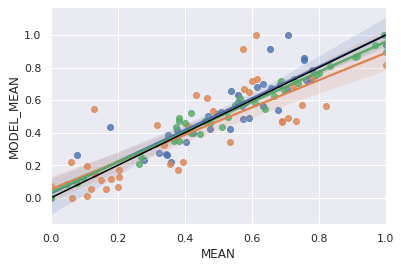

In [39]:
sns.set_theme(style="darkgrid")

sns.regplot(normalized_df['NEAR0'], normalized_df['NEAR0_M'])
sns.regplot(normalized_df['NEAR0_P02'], normalized_df['NEAR0_P02_M'])
sns.regplot(normalized_df['MEAN'], normalized_df['MODEL_MEAN'])
plt.plot([0,1],[0,1], color='black')

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

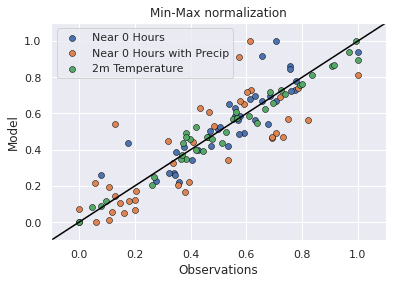

In [97]:
sns.set_theme(style="darkgrid")

sns.scatterplot(normalized_df['NEAR0'], normalized_df['NEAR0_M'], edgecolor='black', label='Near 0 Hours')
sns.scatterplot(normalized_df['NEAR0_P02'], normalized_df['NEAR0_P02_M'], edgecolor='black', label='Near 0 Hours with Precip')
sns.scatterplot(normalized_df['MEAN'], normalized_df['MODEL_MEAN'], edgecolor='black', label='2m Temperature')
plt.plot([-0.5,1.5],[-0.5,1.5], color='black')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('Observations')
plt.ylabel('Model')
plt.title('Min-Max normalization')
plt.savefig('scatter_normalized.png')

In [100]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['NEAR0'],df_plot['NEAR0_M'])

In [105]:
r_value

0.8873498561344013

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

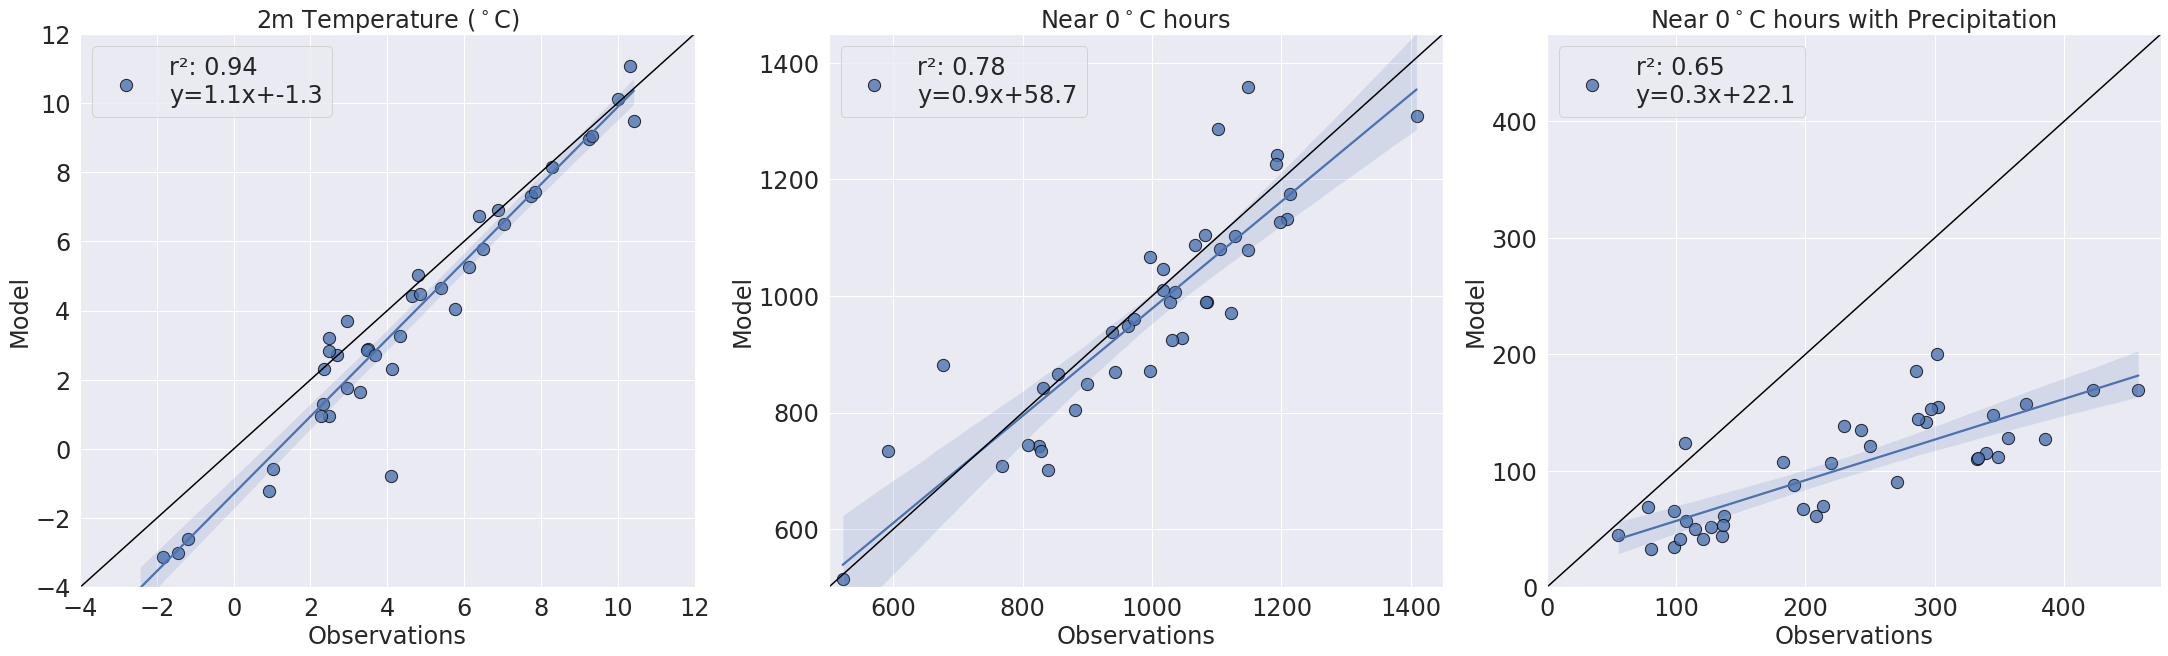

In [5]:
sns.set_theme(style="darkgrid")
f, axs = plt.subplots(1, 3, figsize=(30, 9), constrained_layout=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['NEAR0'],df_plot['NEAR0_M'])

sns.regplot(df_plot['NEAR0'], df_plot['NEAR0_M'], ax=axs[1], scatter_kws={'edgecolors':'black', 's':150, 'lw':1}, label=f'r²: {r_value*r_value:.2f}\ny={slope:.1f}x+{intercept:.1f}')
axs[1].legend(fontsize=24)
axs[1].plot([500,1500],[500,1500], color='black')
axs[1].set_title(r'Near 0${\rm ^\circ C}$ hours', fontsize=24)
axs[1].set_xlim(500,1450)
axs[1].set_ylim(500,1450)
axs[1].set_xlabel('Observations', fontsize=24)
axs[1].set_ylabel('Model', fontsize=24)
axs[1].tick_params(labelsize=24)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['NEAR0_P02'],df_plot['NEAR0_P02_M'])


sns.regplot(df_plot['NEAR0_P02'], df_plot['NEAR0_P02_M'], ax=axs[2], scatter_kws={'edgecolors':'black', 's':150, 'lw':1}, label=f'r²: {r_value*r_value:.2f}\ny={slope:.1f}x+{intercept:.1f}')
axs[2].plot([0,500],[0,500], color='black')
axs[2].legend(fontsize=24)
axs[2].set_xlim(0,475)
axs[2].set_ylim(0,475)
axs[2].set_title(r'Near 0${\rm ^\circ C}$ hours with Precipitation', fontsize=24)
axs[2].set_xlabel('Observations', fontsize=24)
axs[2].set_ylabel('Model', fontsize=24)
axs[2].tick_params(labelsize=24)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['MEAN'],df_plot['MODEL_MEAN'])

sns.regplot(df_plot['MEAN'], df_plot['MODEL_MEAN'], ax=axs[0], scatter_kws={'edgecolors':'black', 's':150, 'lw':1}, label=f'r²: {r_value*r_value:.2f}\ny={slope:.1f}x+{intercept:.1f}')
axs[0].legend(fontsize=24)
axs[0].plot([-4,12],[-4,12], color='black')
axs[0].set_xlim(-4,12)
axs[0].set_ylim(-4,12)
axs[0].set_title(r'2m Temperature (${\rm ^\circ C}$)', fontsize=24)
axs[0].set_xlabel('Observations', fontsize=24)
axs[0].set_ylabel('Model', fontsize=24)
axs[0].tick_params(labelsize=24)

#plt.show()
plt.savefig('scatter_plots_rvalues_v2.png', facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

<AxesSubplot:xlabel='MEAN', ylabel='MODEL_MEAN'>

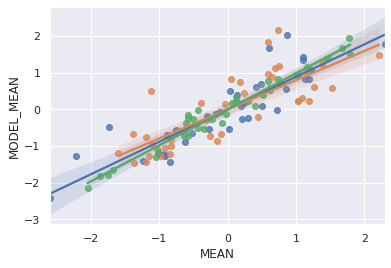

In [35]:
sns.set_theme(style="darkgrid")

sns.regplot(normalized_mean_df['NEAR0'], normalized_mean_df['NEAR0_M'])
sns.regplot(normalized_mean_df['NEAR0_P02'], normalized_mean_df['NEAR0_P02_M'])
sns.regplot(normalized_mean_df['MEAN'], normalized_mean_df['MODEL_MEAN'])
#sns.plot([500,1500],[500,1500], color='black')

In [20]:
df_plot

,LAT,LON,PEAK1,PEAK2,NEAR0,NEAR0_P01,NEAR0_P02,MEAN,STD,MODEL_MEAN,MODEL_STD,RMSE,BIAS,NEAR0_M,NEAR0_P01_M,NEAR0_P02_M
CITY,,,,,,,,,,,,,,,,
CALGARY INTL A,-114.02,51.11,15,-1,1102.42,137.24,137.24,4.64,11.13,4.41,12.03,6.06,0.24,1287.15,83.23,61.00
COLD LAKE A,-110.28,54.42,16,13,898.87,120.73,120.73,2.49,13.38,0.96,14.99,6.28,1.53,848.85,58.46,41.46
EDMONTON INTL A,-113.58,53.32,13,16,1066.97,126.94,126.94,2.48,12.55,3.20,13.41,6.72,-0.72,1086.85,72.15,52.00
GRANDE PRAIRIE A,-118.89,55.18,16,13,997.58,107.75,107.75,2.36,12.93,2.32,13.16,6.16,0.04,1067.15,74.08,56.62
CRANBROOK A,-115.78,49.61,13,-1,1193.20,197.73,197.73,6.38,10.75,6.72,11.06,5.93,-0.35,1241.23,100.23,67.23
KAMLOOPS A,-120.44,50.70,14,16,1149.03,98.56,98.56,9.24,10.08,8.95,10.16,5.85,0.29,1358.62,100.38,65.54
PORT HARDY A,-127.37,50.68,15,-1,676.97,106.66,106.66,8.29,4.69,8.14,5.53,3.71,0.15,881.15,164.15,123.54
VANCOUVER INTL A,-123.18,49.20,15,-1,521.75,78.61,78.61,10.33,6.00,11.08,6.67,3.94,-0.75,514.62,80.00,69.23
VICTORIA INTL A,-123.43,48.65,15,-1,591.58,55.19,55.19,10.00,5.91,10.12,6.76,4.88,-0.11,734.15,55.23,44.85


In [23]:
np.nanmean(df_merged['T2 (C)']), np.nanmean(df_merged['Temp (°C)'])

(4.207125495581919, 4.476174610400302)

In [9]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Precip. Amount (mm),Precip. Amount Flag
0,-106.72,52.17,SASKATOON DIEFENBAKER INT'L A,4057120,2011-01-01 00:00:00,2011,1,1,00:00,-25.2,...,NaN,95.76,NaN,NaN,NaN,-34.0,NaN,Clear,NaN,NaN
1,-106.72,52.17,SASKATOON DIEFENBAKER INT'L A,4057120,2011-01-01 01:00:00,2011,1,1,01:00,-26.4,...,NaN,95.74,NaN,NaN,NaN,-34.0,NaN,Snow,NaN,NaN
2,-106.72,52.17,SASKATOON DIEFENBAKER INT'L A,4057120,2011-01-01 02:00:00,2011,1,1,02:00,-25.4,...,NaN,95.70,NaN,NaN,NaN,-33.0,NaN,Mainly Clear,NaN,NaN
3,-106.72,52.17,SASKATOON DIEFENBAKER INT'L A,4057120,2011-01-01 03:00:00,2011,1,1,03:00,-26.2,...,NaN,95.66,NaN,NaN,NaN,-34.0,NaN,Mainly Clear,NaN,NaN
4,-106.72,52.17,SASKATOON DIEFENBAKER INT'L A,4057120,2011-01-01 04:00:00,2011,1,1,04:00,-26.5,...,NaN,95.62,NaN,NaN,NaN,-35.0,NaN,Clear,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-106.70,52.17,SASKATOON INTL A,4057152,2013-04-30 19:00:00,2013,4,30,19:00,1.5,...,NaN,96.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
716,-106.70,52.17,SASKATOON INTL A,4057152,2013-04-30 20:00:00,2013,4,30,20:00,-0.2,...,NaN,96.13,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,NaN
717,-106.70,52.17,SASKATOON INTL A,4057152,2013-04-30 21:00:00,2013,4,30,21:00,-1.4,...,NaN,96.21,NaN,NaN,NaN,-5.0,NaN,Mostly Cloudy,NaN,NaN
718,-106.70,52.17,SASKATOON INTL A,4057152,2013-04-30 22:00:00,2013,4,30,22:00,-1.0,...,NaN,96.28,NaN,NaN,NaN,-6.0,NaN,NaN,NaN,NaN


In [10]:
df['Precip. Amount Flag'].unique()

array([nan])

In [12]:
df['Weather'].unique()

array(['Clear', 'Snow', 'Mainly Clear', 'Mostly Cloudy', 'Snow,Fog',
       'Cloudy', 'Fog', 'Snow Grains,Fog', 'Freezing Fog',
       'Ice Crystals,Blowing Snow', 'Ice Crystals', 'Ice Crystals,Fog',
       'Snow,Blowing Snow', 'Snow Showers', 'Freezing Rain', 'Rain',
       'Freezing Drizzle,Freezing Fog', 'Snow Grains,Freezing Fog',
       'Blowing Snow', 'Freezing Drizzle,Fog', 'Moderate Snow', 'Haze',
       'Snow Grains', 'Heavy Snow', 'Smoke', 'Rain Showers', 'Rain,Fog',
       'Moderate Rain,Fog', 'Drizzle,Fog', 'Drizzle', 'Thunderstorms',
       'Thunderstorms,Rain Showers', 'Rain Showers,Fog',
       'Moderate Rain Showers,Fog',
       'Thunderstorms,Moderate Rain Showers,Fog',
       'Heavy Rain Showers,Fog', 'Moderate Rain', nan,
       'Thunderstorms,Heavy Rain Showers',
       'Thunderstorms,Moderate Rain Showers', 'Moderate Rain Showers',
       'Heavy Thunderstorms,Heavy Rain Showers', 'Rain,Snow,Fog',
       'Moderate Snow,Freezing Fog', 'Snow,Freezing Fog', 'Snow Pelle

In [26]:
np.nanmean((df_merged['T2 (C)'] - df_merged['Temp (°C)'])**2)

36.67955140108788

In [25]:
np.sqrt((np.nanmean(df_merged['T2 (C)']) - np.nanmean(df_merged['Temp (°C)']))**2)

0.2690491148183831

In [29]:
a = pd.DataFrame({})
a['t_model'] = df_merged['T2 (C)']
a['t_obs'] = df_merged['Temp (°C)']

In [34]:
b = a.dropna()

In [35]:
mean_squared_error(b['t_model'], b['t_obs'])

36.67955140108788

In [15]:
merged_inner = pd.merge(left=df, right=df_m, left_on='Date/Time (LST)', right_on='Time')

In [17]:
merged_inner.iloc[9000]

Longitude (x)                      -114.02
Latitude (y)                         51.11
Station Name               CALGARY INT'L A
Climate ID                         3031093
Date/Time (LST)        2001-08-14 00:00:00
Year                                  2001
Month                                    8
Day                                     14
Time (LST)                           00:00
Temp (°C)                             17.1
Temp Flag                              NaN
Dew Point Temp (°C)                    9.7
Dew Point Temp Flag                    NaN
Rel Hum (%)                           62.0
Rel Hum Flag                           NaN
Wind Dir (10s deg)                    32.0
Wind Dir Flag                          NaN
Wind Spd (km/h)                       22.0
Wind Spd Flag                          NaN
Visibility (km)                       22.5
Visibility Flag                        NaN
Stn Press (kPa)                      89.65
Stn Press Flag                         NaN
Hmdx       

In [20]:
df_m = pd.read_csv(glob(f'{model}/{c[:6]}*CTRL*csv'.replace(' ', '_'))[0], index_col=0)

In [38]:
df_m

,Time,PR (mm),SN (mm),PSFC (Pa),T2 (K),U10 (m s-1),V10 (m s-1),TD2 (C),T2 (C)
1,2000-10-01 01:00:00,0.000000,0.0,94121.800,284.64570,5.985001,-5.592552,6.739297,11.49570
2,2000-10-01 02:00:00,0.000000,0.0,94298.810,283.05606,5.771887,-4.688837,3.378251,9.90606
3,2000-10-01 03:00:00,0.000000,0.0,94417.234,281.63043,4.837546,-3.172069,2.032307,8.48043
4,2000-10-01 04:00:00,0.000000,0.0,94513.910,280.40540,4.054398,-1.564056,1.403423,7.25540
5,2000-10-01 05:00:00,0.000000,0.0,94539.100,279.97186,4.156006,-1.271690,0.093600,6.82186
...,...,...,...,...,...,...,...,...,...
113947,2013-09-30 19:00:00,0.000310,0.0,93443.400,287.29385,3.026214,4.595267,5.080667,14.14385
113948,2013-09-30 20:00:00,0.000042,0.0,93395.140,289.13004,2.424829,4.553112,5.495970,15.98004
113949,2013-09-30 21:00:00,0.000016,0.0,93366.695,289.83887,3.800511,4.875011,5.486801,16.68887
113950,2013-09-30 22:00:00,0.293120,0.0,93320.810,288.56662,3.047957,5.729814,7.022404,15.41662


In [6]:
f'{model}/{c}*CTRL*csv'.replace(' ', '_')

"/home/cruman/Scripts/EventDistributionT2M/CSV/CALGARY_INT'L_A*CTRL*csv"

In [110]:
jellyfish.jaro_winkler_similarity('QUEBEC INTL A', "QUEBEC:JEAN LESAGE INTL A")

0.8208671328671329

In [68]:
mask = (df['Date/Time (LST)'] > datei) & (df['Date/Time (LST)'] <= datef)
df = df.loc[mask]

In [25]:
a, b, c = calcNear0(df)
dist = calcDist(df['Temp (°C)'].to_numpy())

In [43]:
get_2peaks(dist)

(16, -1)

In [76]:
dist2 = np.histogram(df['Temp (°C)'].to_numpy(), bins=np.arange(-50,48,4))

In [64]:
dist2[0].sum()

521737

In [75]:
len(df)

107399

<BarContainer object of 24 artists>

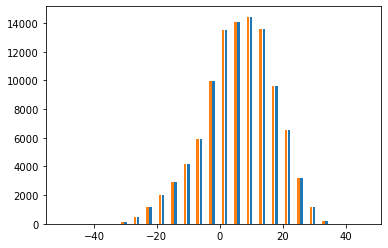

In [77]:
l = np.arange(-50,48,4)
plt.bar(l, dist)
plt.bar(l[1:]-1, dist2[0])

In [12]:
print(a, b, c)

64734 0 0


In [15]:
df['Temp (°C)'].to_numpy()

525960

In [9]:
len(df.loc[mask])

107399

In [44]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Precip. Amount (mm),Precip. Amount Flag
0,-114.02,51.11,CALGARY INT'L A,3031093,1981-01-01 00:00,1981,1,1,00:00,-5.3,...,NaN,90.27,NaN,NaN,NaN,-10.0,NaN,Clear,NaN,NaN
1,-114.02,51.11,CALGARY INT'L A,3031093,1981-01-01 01:00,1981,1,1,01:00,-7.6,...,NaN,90.27,NaN,NaN,NaN,-10.0,NaN,Mainly Clear,NaN,NaN
2,-114.02,51.11,CALGARY INT'L A,3031093,1981-01-01 02:00,1981,1,1,02:00,-8.1,...,NaN,90.24,NaN,NaN,NaN,NaN,NaN,Mainly Clear,NaN,NaN
3,-114.02,51.11,CALGARY INT'L A,3031093,1981-01-01 03:00,1981,1,1,03:00,-7.7,...,NaN,90.18,NaN,NaN,NaN,-11.0,NaN,Clear,NaN,NaN
4,-114.02,51.11,CALGARY INT'L A,3031093,1981-01-01 04:00,1981,1,1,04:00,-6.6,...,NaN,90.12,NaN,NaN,NaN,-10.0,NaN,Clear,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,-114.02,51.11,CALGARY INT'L A,3031093,1967-12-31 19:00,1967,12,31,19:00,-12.8,...,NaN,88.41,NaN,NaN,NaN,-21.0,NaN,Snow,NaN,NaN
740,-114.02,51.11,CALGARY INT'L A,3031093,1967-12-31 20:00,1967,12,31,20:00,-15.0,...,NaN,88.47,NaN,NaN,NaN,-24.0,NaN,Snow,NaN,NaN
741,-114.02,51.11,CALGARY INT'L A,3031093,1967-12-31 21:00,1967,12,31,21:00,-16.1,...,NaN,88.59,NaN,NaN,NaN,-25.0,NaN,Snow,NaN,NaN
742,-114.02,51.11,CALGARY INT'L A,3031093,1967-12-31 22:00,1967,12,31,22:00,-16.7,...,NaN,88.69,NaN,NaN,NaN,-24.0,NaN,Snow,NaN,NaN


In [24]:
next(os.walk(f'{f}/pv[]'))[1]

['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK']

In [13]:
list_files(f'{f}/{provinces[0]}')

['/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB', "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A", "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012", '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INTL A', '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INTL A/3031092_2012_2021', '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/COLD LAKE A', '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/COLD LAKE A/3081680_1954_2021', "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/EDMONTON INT'L A", "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/EDMONTON INT'L A/3012205_1961_2012", '/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB

["/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_01-1981_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_01-1992_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_02-1958_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_02-1969_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_02-1989_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climate_Historical_Hourly_data/LocalStandardTime/AB/CALGARY INT'L A/3031093_1953_2012/en_climate_hourly_AB_3031093_02-2009_P1H.csv",
 "/home/cruman/Data/CONUS_I/Climat

In [19]:
s = os.walk(f'{f}/{provinces[0]}')
#for a, b, c in s:
    #print("a", a)
#    print("b", b)

b ["CALGARY INT'L A", 'CALGARY INTL A', 'COLD LAKE A', "EDMONTON INT'L A", 'EDMONTON INTL A', 'GRANDE PRAIRIE A']
b ['3031093_1953_2012']
b []
b ['3031092_2012_2021']
b []
b ['3081680_1954_2021']
b []
b ['3012205_1961_2012']
b []
b ['3012216_2012_2021']
b []
b ['3072920_1953_2013', '3072921_2013_2021']
b []
b []


In [23]:
next(os.walk(f'{f}/{provinces[0]}'))[1]

["CALGARY INT'L A",
 'CALGARY INTL A',
 'COLD LAKE A',
 "EDMONTON INT'L A",
 'EDMONTON INTL A',
 'GRANDE PRAIRIE A']

In [8]:
len(a)

31428

In [9]:
def list_files(dir):                                                                                                  
    r = []                                                                                                            
    subdirs = [x[0] for x in os.walk(dir)]     
    print(subdirs)
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).__next__()[2]                                                                             
        if (len(files) > 0):                                                                                          
            for file in files:                                                                                        
                r.append(os.path.join(subdir, file))                                                                         
    return r 